## Genetic

In [7]:
import random
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import copy

In [8]:
OFFSET = 10

def generate_point(width, height):
    x = random.randrange(0 - OFFSET, width + OFFSET, 1)
    y = random.randrange(0 - OFFSET, height + OFFSET, 1)

    return (x, y)

class Triangle:
    def __init__(self, img_width, img_height):
        self.points = []
        for i in range(3):
            self.points.append(generate_point(img_width, img_height))
        
        self.color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        
        self._img_width = img_width
        self._img_height = img_height

    def mutate_point(self):
        point = random.randint(0, 2)

        self.points[point] = generate_point(self._img_width, self._img_height)

    def mutate_color(self):
        colors = list(self.color)
        channel = random.randint(0, 3)

        colors[channel] = random.randint(0, 255)
        self.color = tuple(colors)

In [9]:
class Chromosome:  
    def __init__(self,img_height, img_width, target_image, num_triangles):
        self.img_height = img_height
        self.img_width = img_width  
        self.background_color = (0, 0, 0, 255)
        self.triangles = [Triangle(img_width, img_height) for i in range(num_triangles)]
        self.target_image = target_image
        self.num_trinagles = num_triangles
        self.fit = -math.inf

    def mutate(self):
        triangle = random.choice(self.triangles)
        self.fit = -math.inf
        change = random.randint(0, 1)

        if(change == 0):
            triangle.mutate_point()
        elif(change == 1):
            triangle.mutate_color()
    
    def draw(self) -> Image:
        size = self.target_image.size
        img = Image.new('RGB', size, self.background_color)
        draw = Image.new('RGBA', size)
        pdraw = ImageDraw.Draw(draw)
        for triangle in self.triangles:
            colour = triangle.color
            points = triangle.points
            pdraw.polygon(points, fill=colour, outline=colour)
            img.paste(draw, mask=draw)
        return img
        
    def fitness(self) -> float:
        created_image = np.array(self.draw())
        target_image = np.array(self.target_image)

        self.fit = -(np.sum((created_image/255 - target_image/255) ** 2))

        return self.fit

In [10]:
class GeneticAlgorithm():
    def __init__(self,max_width,max_height,target_image, population_size, triangles_number):
        self.population_size = population_size
        self.max_width = max_width
        self.max_height = max_height
        self.population = [Chromosome(max_height,max_width,target_image, triangles_number) for i in range(population_size)]
        self.target_image = target_image
    
    def calc_fitnesses(self):
        fitnesses = []
        for chromosome in self.population:  
            fitnesses.append(chromosome.fitness())
        return fitnesses
    
    def sort_population(self, fitnesses):
        return [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0], reverse=True)]
    
    #TODO: apply cross over
    def cross_over(self):
        random.shuffle(self.population)
        pc = 0.8

        for i in range(0, self.population_size, 2):
            p = random.random()

            if(p <= pc):
                point = random.randint(0, self.population[i].num_trinagles - 1)

                child1 = self.population[i].triangles[ : point] + self.population[i + 1].triangles[point : ]
                child2 = self.population[i + 1].triangles[ : point] + self.population[i].triangles[point : ]

                self.population[i].triangles = child1
                self.population[i + 1].triangles = child2

                self.population[i].fit = -math.inf
                self.population[i + 1].fit = -math.inf

    def mutation(self):
        pm = 0.2

        for chromosome in self.population:
            p = random.random()

            if(p < pm):
                chromosome.mutate()
    
    def run(self, n_generations):
        for iteration in range(n_generations):
            fitnesses = self.calc_fitnesses()
            sorted_population = self.sort_population(fitnesses)
            best_chromosomes = copy.deepcopy(sorted_population[0 : int(0.3 * self.population_size)])
            
            if(iteration % 10 == 0):
                #this part shows the log for fitness
                fit_arr = np.array(fitnesses)
                print(f"Fitness in Generation {iteration}: mean: {np.mean(fit_arr)}, max: {np.max(fit_arr)} min: {np.min(fit_arr)}")
                if(iteration % 100 == 0):
                    self.get_best_of_population()

            self.cross_over()
            self.mutation()

            fitnesses = self.calc_fitnesses()
            sorted_new_population = self.sort_population(fitnesses)

            self.population = best_chromosomes + sorted_new_population[0 : int(0.7 * self.population_size)]

    def get_best_of_population(self):
        fitnesses = self.calc_fitnesses()
        sorted_population = [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]              
        best_population = sorted_population[-1]
        image = best_population.draw()    
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [11]:
def resize(image, max_size):
    new_width = int((max_size/max(image.size[0], image.size[1]))* image.size[0])
    new_height = int((max_size/max(image.size[0], image.size[1]))* image.size[1])
    image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)  
    return image

Fitness in Generation 0: mean: -3614.1499684736646, max: -2824.139792387543 min: -4592.123706266821


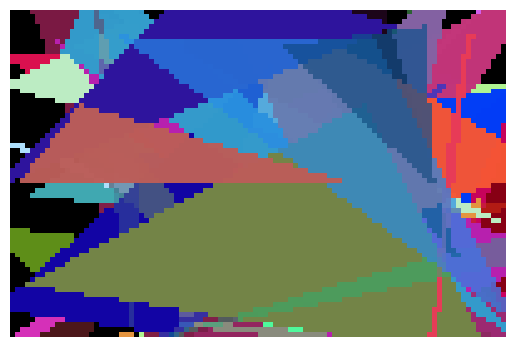

Fitness in Generation 10: mean: -2465.2070892733564, max: -2322.6292195309497 min: -2578.0028758169938
Fitness in Generation 20: mean: -1992.170770011534, max: -1791.7938485198001 min: -2065.6027527873894
Fitness in Generation 30: mean: -1744.123037600923, max: -1714.1421145713186 min: -1761.260453671665
Fitness in Generation 40: mean: -1653.156369088812, max: -1612.40399846213 min: -1666.2594386774317
Fitness in Generation 50: mean: -1535.8479606305266, max: -1453.15231064975 min: -1571.2802614379084
Fitness in Generation 60: mean: -1429.360998077662, max: -1411.7388696655134 min: -1434.9223375624758
Fitness in Generation 70: mean: -1368.4021434832757, max: -1326.921168781238 min: -1383.0129796232218
Fitness in Generation 80: mean: -1278.8073408688963, max: -1268.1290580545945 min: -1285.867666282199
Fitness in Generation 90: mean: -1247.8416344482891, max: -1216.8856747404843 min: -1259.6444905805458
Fitness in Generation 100: mean: -1184.6483592464438, max: -1164.5148635140329 min: 

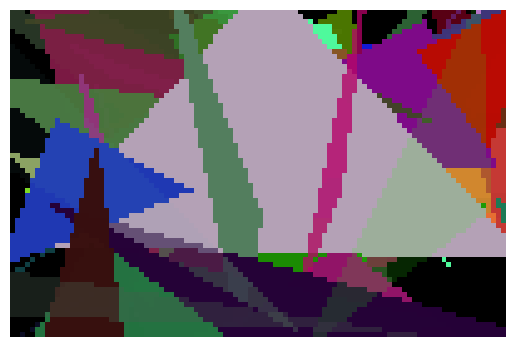

Fitness in Generation 110: mean: -1122.6795896962703, max: -1099.4625759323337 min: -1131.9582006920414
Fitness in Generation 120: mean: -1057.2251613994617, max: -1043.0532410611304 min: -1063.033110342176
Fitness in Generation 130: mean: -1018.3344485966935, max: -1002.0706651287966 min: -1028.5432833525567
Fitness in Generation 140: mean: -989.2493779315648, max: -976.6133025759324 min: -998.3033756247597
Fitness in Generation 150: mean: -962.203044059977, max: -952.8531949250289 min: -964.7795309496349
Fitness in Generation 160: mean: -941.0558216070742, max: -921.432064590542 min: -948.2948096885814
Fitness in Generation 170: mean: -917.189081430219, max: -912.7946635909263 min: -919.0459823144944
Fitness in Generation 180: mean: -897.037353940792, max: -880.7639215686274 min: -900.0648673587082
Fitness in Generation 190: mean: -874.1285431757017, max: -857.8599000384468 min: -878.9709957708574
Fitness in Generation 200: mean: -848.7646929642447, max: -843.8807535563245 min: -852.

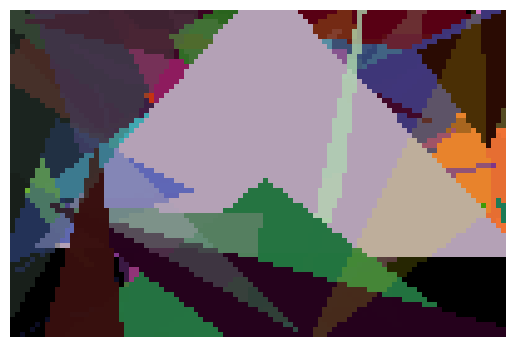

Fitness in Generation 210: mean: -831.8739657054979, max: -827.6640215301807 min: -833.1432525951558
Fitness in Generation 220: mean: -810.0918880430603, max: -770.1803613994617 min: -822.1579084967319
Fitness in Generation 230: mean: -754.4770903498653, max: -752.8339561707036 min: -757.7321645520952
Fitness in Generation 240: mean: -744.1841620915033, max: -742.5887120338331 min: -744.6941022683584
Fitness in Generation 250: mean: -736.5264043060362, max: -731.560645905421 min: -739.8837985390234
Fitness in Generation 260: mean: -726.0675761630143, max: -721.1255670895808 min: -728.7609381007305
Fitness in Generation 270: mean: -713.5976199923108, max: -706.285044213764 min: -719.0918108419838
Fitness in Generation 280: mean: -699.723939715494, max: -694.3421760861207 min: -701.7309650134564
Fitness in Generation 290: mean: -675.3392424452135, max: -670.1755324875047 min: -677.7879738562091
Fitness in Generation 300: mean: -667.3385547097271, max: -665.3174317570165 min: -669.9359630

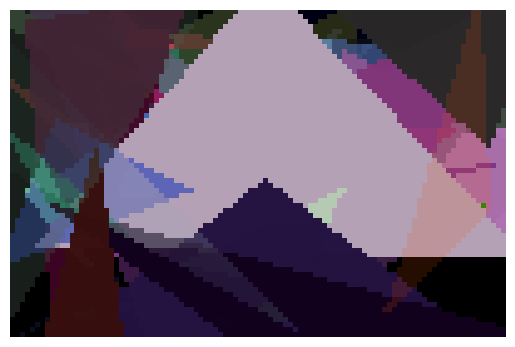

Fitness in Generation 310: mean: -664.4979746251441, max: -664.0875048058439 min: -665.2752326028451
Fitness in Generation 320: mean: -661.3687234140714, max: -632.6671741637831 min: -662.752372164552
Fitness in Generation 330: mean: -628.6253385620915, max: -625.6439523260284 min: -629.9934179161861
Fitness in Generation 340: mean: -624.8254877354863, max: -624.5154632833526 min: -624.9217993079585
Fitness in Generation 350: mean: -621.8321876201461, max: -621.4396001537871 min: -622.0552864282968
Fitness in Generation 360: mean: -617.9715358708189, max: -616.954186851211 min: -618.0281737793157
Fitness in Generation 370: mean: -612.7615317185698, max: -610.9158477508649 min: -615.5282583621685
Fitness in Generation 380: mean: -604.8490094579008, max: -599.8728027681661 min: -606.3227681660899
Fitness in Generation 390: mean: -596.3849602460592, max: -594.9952018454441 min: -598.0983467896963
Fitness in Generation 400: mean: -593.7258429834678, max: -591.1086812764322 min: -594.139054

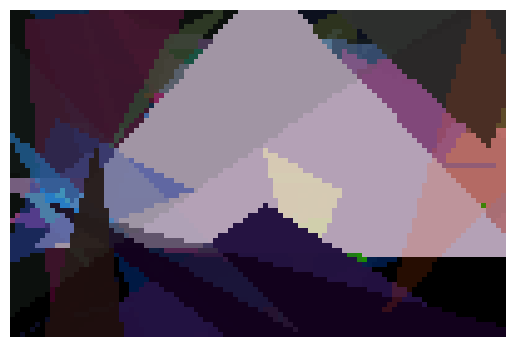

Fitness in Generation 410: mean: -586.4349954632834, max: -584.4505959246444 min: -586.7770088427528
Fitness in Generation 420: mean: -579.6366594386774, max: -577.5344559784697 min: -580.7034832756632
Fitness in Generation 430: mean: -576.5898383698577, max: -575.16891964629 min: -577.4443829296424
Fitness in Generation 440: mean: -571.5804530565167, max: -568.9845444059977 min: -573.4931641676278
Fitness in Generation 450: mean: -567.3709837754709, max: -565.1498961937716 min: -568.5034063821607
Fitness in Generation 460: mean: -563.7530912725873, max: -561.2294655901576 min: -565.035140330642
Fitness in Generation 470: mean: -558.8674881968474, max: -547.874832756632 min: -560.7978931180315
Fitness in Generation 480: mean: -539.0658549788543, max: -533.5060053825453 min: -542.8960553633218
Fitness in Generation 490: mean: -528.3310492887351, max: -526.9009304113803 min: -532.4460438292965
Fitness in Generation 500: mean: -524.488646520569, max: -521.9321491733948 min: -525.906097654

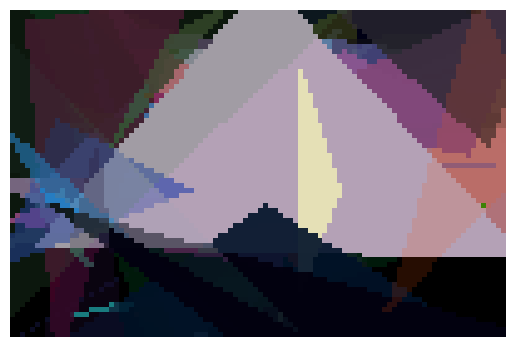

Fitness in Generation 510: mean: -516.1746242214533, max: -515.007166474433 min: -517.4920261437909
Fitness in Generation 520: mean: -513.8011241830064, max: -510.9942945021146 min: -514.3890042291426
Fitness in Generation 530: mean: -509.22157385620915, max: -507.27367935409455 min: -509.99444828911965
Fitness in Generation 540: mean: -501.9317742406767, max: -499.13059592464435 min: -505.4931334102269
Fitness in Generation 550: mean: -496.07003613994607, max: -491.68533640907344 min: -498.4070280661284
Fitness in Generation 560: mean: -489.1213776239908, max: -487.2991311034217 min: -489.8516262975778
Fitness in Generation 570: mean: -485.1209990003845, max: -483.70186851211076 min: -486.0244059976932
Fitness in Generation 580: mean: -482.0104286043829, max: -481.6967627835448 min: -482.1377008842753
Fitness in Generation 590: mean: -480.725844521338, max: -479.35577085736253 min: -481.3165397923876
Fitness in Generation 600: mean: -477.6287283352556, max: -476.78705113417914 min: -4

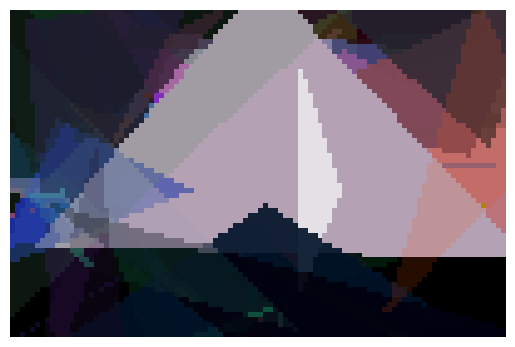

Fitness in Generation 610: mean: -474.9418900422914, max: -474.15223375624754 min: -475.61176470588225
Fitness in Generation 620: mean: -472.7342216070743, max: -467.5882199154172 min: -473.92798154555936
Fitness in Generation 630: mean: -466.5148502883507, max: -465.8642829680892 min: -466.8556093810073
Fitness in Generation 640: mean: -465.04932625913113, max: -463.7554171472511 min: -465.362891195694
Fitness in Generation 650: mean: -462.47987850826604, max: -461.68944252210684 min: -462.6585774702038
Fitness in Generation 660: mean: -461.00274356016916, max: -459.8729411764706 min: -461.5182622068435
Fitness in Generation 670: mean: -457.9696716647443, max: -457.2868281430219 min: -458.84981161091883
Fitness in Generation 680: mean: -456.3726366782007, max: -455.81124183006534 min: -456.90640522875816
Fitness in Generation 690: mean: -455.38282045367174, max: -454.8346174548251 min: -455.7289811610919
Fitness in Generation 700: mean: -454.60378193002697, max: -454.49445597846983 mi

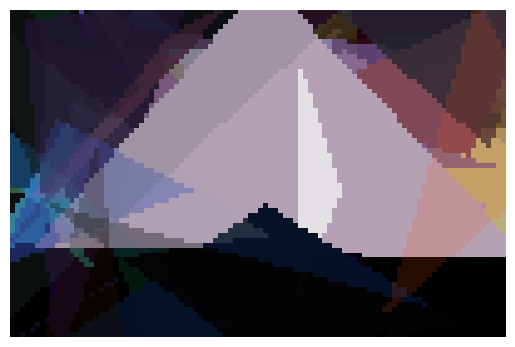

Fitness in Generation 710: mean: -453.13940023068056, max: -451.70168396770475 min: -453.66323721645523
Fitness in Generation 720: mean: -449.9513894655902, max: -448.6722798923491 min: -450.40805843906185
Fitness in Generation 730: mean: -447.6350511341792, max: -446.0688350634372 min: -447.7856055363322
Fitness in Generation 740: mean: -445.41655670895807, max: -444.2491349480969 min: -445.89051903114193
Fitness in Generation 750: mean: -443.35289257977695, max: -442.2895347943099 min: -443.7623836985775
Fitness in Generation 760: mean: -438.79312818146866, max: -437.66312956555174 min: -439.44007689350246
Fitness in Generation 770: mean: -435.8942329873126, max: -435.70579008073815 min: -436.1186312956555
Fitness in Generation 780: mean: -435.4997462514418, max: -435.31677047289503 min: -435.6983467896963
Fitness in Generation 790: mean: -435.1413723952326, max: -435.0443983083429 min: -435.24478277585547
Fitness in Generation 800: mean: -434.86223790849675, max: -434.4952095347943 

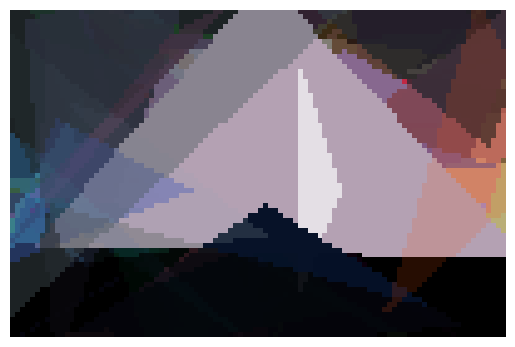

Fitness in Generation 810: mean: -431.9490638985005, max: -431.30176086120724 min: -433.9639215686274
Fitness in Generation 820: mean: -430.7228081507113, max: -430.04773548635137 min: -430.93379469434836
Fitness in Generation 830: mean: -429.2398274509804, max: -429.01078046905036 min: -429.42180699730875
Fitness in Generation 840: mean: -428.7278372933487, max: -428.0334486735871 min: -428.8050903498654
Fitness in Generation 850: mean: -427.8499555555555, max: -427.75043444828907 min: -427.9501576316801
Fitness in Generation 860: mean: -427.088986697424, max: -424.8088888888889 min: -427.477723952326
Fitness in Generation 870: mean: -419.1872156862745, max: -418.4920107650903 min: -419.9427758554402
Fitness in Generation 880: mean: -418.0315441753171, max: -417.7416378316032 min: -418.29098039215677
Fitness in Generation 890: mean: -417.00905436370624, max: -401.2554863514033 min: -417.6900422914263
Fitness in Generation 900: mean: -401.10245720876594, max: -400.93381007304885 min: -

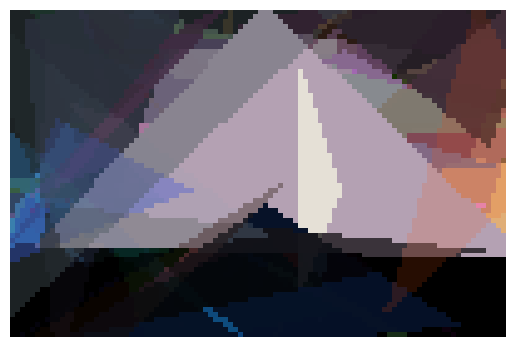

Fitness in Generation 910: mean: -400.5892795078816, max: -399.94176086120723 min: -400.7422991157246
Fitness in Generation 920: mean: -398.83516370626677, max: -394.79507881584004 min: -399.555878508266
Fitness in Generation 930: mean: -393.237664282968, max: -386.92647443291037 min: -394.7036216839677
Fitness in Generation 940: mean: -386.16167996924264, max: -385.4295578623607 min: -386.43972318339104
Fitness in Generation 950: mean: -384.7622778931181, max: -384.12356785851597 min: -384.9804382929643
Fitness in Generation 960: mean: -383.7535252595156, max: -383.520553633218 min: -383.8110111495579
Fitness in Generation 970: mean: -383.3520258362168, max: -382.3378700499807 min: -383.49290272971933
Fitness in Generation 980: mean: -381.80856685890035, max: -381.21703960015384 min: -381.95655517108804
Fitness in Generation 990: mean: -380.23202399077275, max: -379.2915647827759 min: -380.91620146097654
Fitness in Generation 1000: mean: -374.3869490196079, max: -372.5801307189543 min

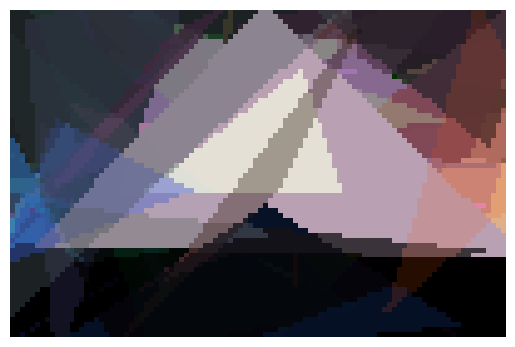

Fitness in Generation 1010: mean: -372.3277111880046, max: -372.17742406766627 min: -372.49190311418687
Fitness in Generation 1020: mean: -372.15941068819694, max: -372.0871510957324 min: -372.17742406766627
Fitness in Generation 1030: mean: -371.5465654748174, max: -371.23446366782014 min: -372.0871510957324
Fitness in Generation 1040: mean: -369.9845893118031, max: -369.8674048442906 min: -371.2013994617455
Fitness in Generation 1050: mean: -369.29211164936567, max: -364.82402153018074 min: -369.86085351787773
Fitness in Generation 1060: mean: -363.8991028066128, max: -363.7072510572856 min: -363.9468973471742
Fitness in Generation 1070: mean: -362.96329596309107, max: -362.76750480584394 min: -363.69945405613225
Fitness in Generation 1080: mean: -362.3153027297194, max: -360.4673125720877 min: -362.70068435217223
Fitness in Generation 1090: mean: -359.86034356016916, max: -359.44504421376394 min: -360.2919184928873
Fitness in Generation 1100: mean: -359.05937070357555, max: -358.823

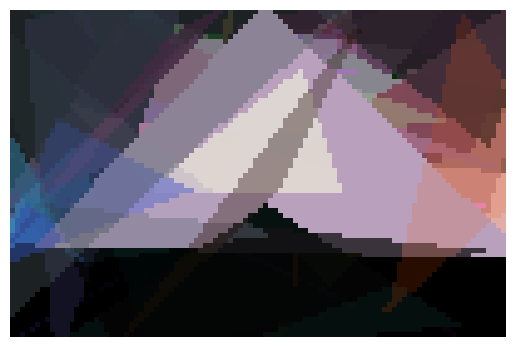

Fitness in Generation 1110: mean: -357.7451444828912, max: -357.4334486735871 min: -358.3480507497116
Fitness in Generation 1120: mean: -356.52776101499427, max: -356.2332026143791 min: -356.76092272203005
Fitness in Generation 1130: mean: -355.8726511341792, max: -355.6087966166859 min: -356.01830065359474
Fitness in Generation 1140: mean: -355.21357846981925, max: -354.99613994617454 min: -355.40209150326797
Fitness in Generation 1150: mean: -354.0968805843906, max: -348.0307420222991 min: -354.6950249903883
Fitness in Generation 1160: mean: -347.51069127258745, max: -347.38826605151866 min: -347.6250519031142
Fitness in Generation 1170: mean: -344.9429050365244, max: -344.55026528258367 min: -347.2705420991926
Fitness in Generation 1180: mean: -344.5330073048828, max: -344.44425990003845 min: -344.55026528258367
Fitness in Generation 1190: mean: -344.3898048442906, max: -344.27683198769705 min: -344.43420222991153
Fitness in Generation 1200: mean: -343.6291592464437, max: -343.15100

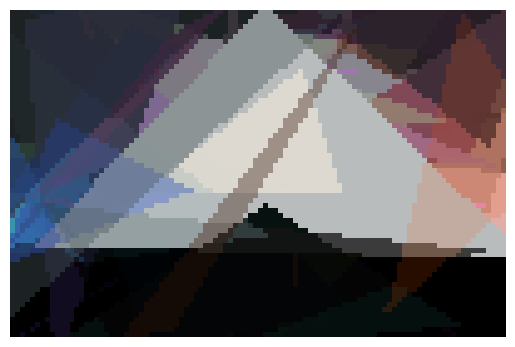

Fitness in Generation 1210: mean: -341.770894886582, max: -340.34986543637064 min: -343.0695117262591
Fitness in Generation 1220: mean: -339.76758908112265, max: -338.9800999615532 min: -340.1695040369089
Fitness in Generation 1230: mean: -338.94113371780094, max: -338.86945021145715 min: -338.9800999615532
Fitness in Generation 1240: mean: -338.4526806612841, max: -338.3496808919646 min: -338.7753633217993
Fitness in Generation 1250: mean: -338.1939617070357, max: -338.09599384851975 min: -338.25202614379083
Fitness in Generation 1260: mean: -337.8737205690119, max: -337.7247366397539 min: -337.9693194925029
Fitness in Generation 1270: mean: -337.6862049980776, max: -337.62755863129564 min: -337.7247366397539
Fitness in Generation 1280: mean: -337.2979420222991, max: -337.14119184928876 min: -337.5749327181854
Fitness in Generation 1290: mean: -336.8103707804691, max: -336.6427835447904 min: -336.97099577085737
Fitness in Generation 1300: mean: -336.15089088812, max: -335.527920030757

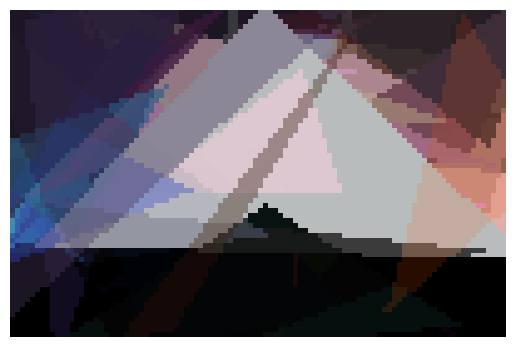

Fitness in Generation 1310: mean: -334.0602580545944, max: -333.3180469050365 min: -334.7771164936563
Fitness in Generation 1320: mean: -332.6297777777778, max: -332.59846212995 min: -332.6870126874279
Fitness in Generation 1330: mean: -332.5371100346021, max: -332.4475970780469 min: -332.5891118800462
Fitness in Generation 1340: mean: -332.32100330642055, max: -332.2790311418685 min: -332.36173779315646
Fitness in Generation 1350: mean: -332.1960089196463, max: -332.11200307574006 min: -332.22205305651676
Fitness in Generation 1360: mean: -331.4206652825836, max: -331.10222222222217 min: -331.51040369088804
Fitness in Generation 1370: mean: -330.9045496347558, max: -330.82981930026915 min: -330.9749173394848
Fitness in Generation 1380: mean: -325.2973376393695, max: -325.2367858515955 min: -325.3541253364091
Fitness in Generation 1390: mean: -325.17325028835063, max: -325.06903498654367 min: -325.23269511726255
Fitness in Generation 1400: mean: -324.9239120338332, max: -323.1567858515

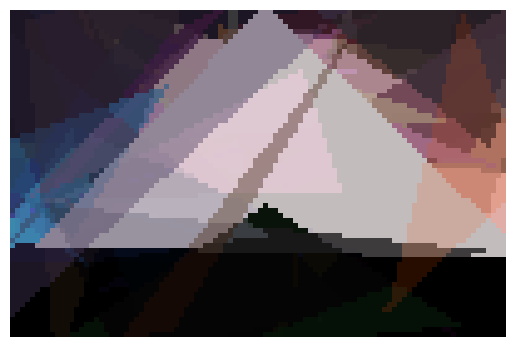

Fitness in Generation 1410: mean: -322.9790818915801, max: -322.84538254517497 min: -323.0002153018071
Fitness in Generation 1420: mean: -322.7542468281431, max: -322.005105728566 min: -322.8311572472127
Fitness in Generation 1430: mean: -321.76721138023845, max: -321.7458054594387 min: -321.7718877354864
Fitness in Generation 1440: mean: -321.70134871203385, max: -321.4334179161861 min: -321.71472510572863
Fitness in Generation 1450: mean: -321.24394801999233, max: -320.6095194156093 min: -321.31646289888505
Fitness in Generation 1460: mean: -320.0890885044214, max: -319.88581314878894 min: -320.2724951941561
Fitness in Generation 1470: mean: -319.3235835447905, max: -318.7312264513649 min: -319.7722722029989
Fitness in Generation 1480: mean: -318.6768624375241, max: -318.5592156862745 min: -318.7312264513649
Fitness in Generation 1490: mean: -318.4594832756632, max: -318.1680123029604 min: -318.5199846212995
Fitness in Generation 1500: mean: -317.9840396770473, max: -317.829234909650

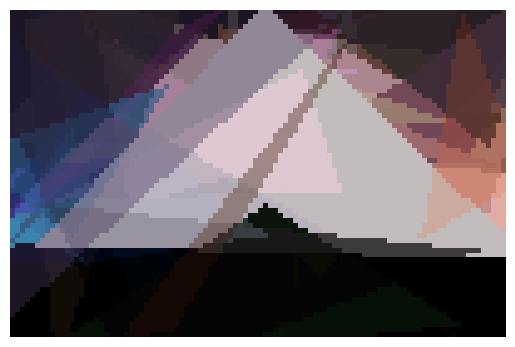

Fitness in Generation 1510: mean: -317.61234694348326, max: -317.5500038446752 min: -317.65019607843135
Fitness in Generation 1520: mean: -317.48588481353335, max: -317.44696655132634 min: -317.5008996539793
Fitness in Generation 1530: mean: -317.05898039215685, max: -316.9638908112265 min: -317.09368704344485
Fitness in Generation 1540: mean: -315.95601261053446, max: -315.88478277585546 min: -315.98812764321417
Fitness in Generation 1550: mean: -315.4609670126875, max: -315.3796847366398 min: -315.51844675124954
Fitness in Generation 1560: mean: -315.3241587081892, max: -314.5506958861976 min: -315.34288350634375
Fitness in Generation 1570: mean: -314.37863437139566, max: -314.0985928489043 min: -314.51700115340253
Fitness in Generation 1580: mean: -314.0325911572472, max: -313.68421376393695 min: -314.0985928489043
Fitness in Generation 1590: mean: -313.51186343713954, max: -313.26702037677813 min: -313.598708189158
Fitness in Generation 1600: mean: -313.17201230296035, max: -312.84

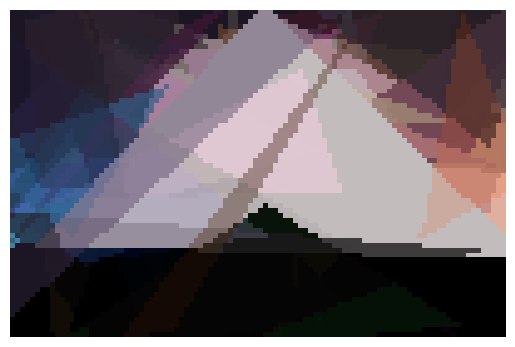

Fitness in Generation 1610: mean: -312.7971657054979, max: -312.7499730872741 min: -312.8160553633218
Fitness in Generation 1620: mean: -312.39424959630907, max: -311.58039215686273 min: -312.4220991926182
Fitness in Generation 1630: mean: -310.16902945021144, max: -309.88255286428296 min: -310.8124567474049
Fitness in Generation 1640: mean: -309.7710698961938, max: -309.65977700884275 min: -309.82105344098426
Fitness in Generation 1650: mean: -309.52040876585926, max: -308.7095117262591 min: -309.63603229527104
Fitness in Generation 1660: mean: -308.4370974240677, max: -308.2048596693579 min: -308.5448673587082
Fitness in Generation 1670: mean: -307.0475607843137, max: -306.16516724336793 min: -307.26385236447516
Fitness in Generation 1680: mean: -304.9388530565167, max: -302.6059361783929 min: -306.16516724336793
Fitness in Generation 1690: mean: -302.40834509803915, max: -301.81983852364476 min: -302.5696578239138
Fitness in Generation 1700: mean: -301.17382329873124, max: -300.8362

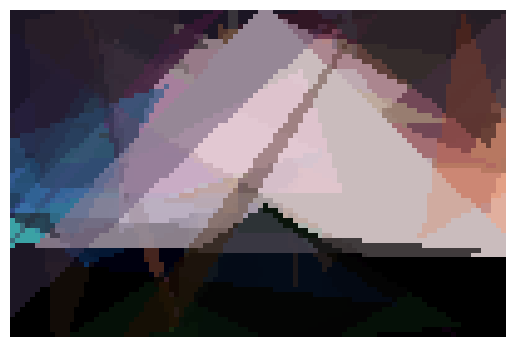

Fitness in Generation 1710: mean: -300.4899432525952, max: -300.2659592464437 min: -300.7785467128027
Fitness in Generation 1720: mean: -299.81148481353324, max: -299.60232218377547 min: -299.9025451749327
Fitness in Generation 1730: mean: -294.60615916955015, max: -294.41616301422533 min: -295.159784698193
Fitness in Generation 1740: mean: -294.2239151095733, max: -293.9507881584006 min: -294.3472049211842
Fitness in Generation 1750: mean: -293.4791320261438, max: -292.93062668204533 min: -293.6662668204537
Fitness in Generation 1760: mean: -292.27261084198386, max: -290.23763168012306 min: -292.8876893502499
Fitness in Generation 1770: mean: -288.4794285274894, max: -287.6525797770088 min: -289.41334871203384
Fitness in Generation 1780: mean: -286.6131269511726, max: -286.3818223760092 min: -286.8294502114571
Fitness in Generation 1790: mean: -286.005200768935, max: -285.7059131103422 min: -286.15123414071513
Fitness in Generation 1800: mean: -284.7333570165321, max: -284.43915417147

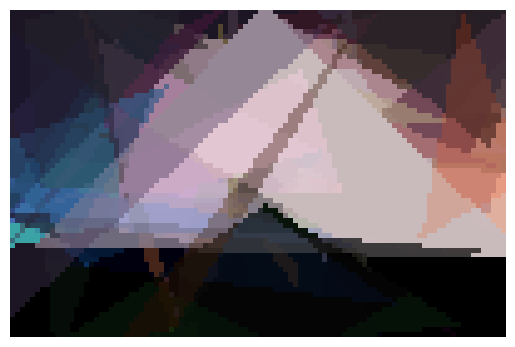

Fitness in Generation 1810: mean: -284.0270625144176, max: -283.86374471357163 min: -284.3237524029219
Fitness in Generation 1820: mean: -283.7605056516724, max: -283.3749788542868 min: -283.8507497116493
Fitness in Generation 1830: mean: -282.75032618223753, max: -282.09770088427524 min: -283.06128412149167
Fitness in Generation 1840: mean: -281.7965447135717, max: -281.19527873894657 min: -282.08527489427144
Fitness in Generation 1850: mean: -280.95750618992696, max: -280.7586005382545 min: -281.08693579392536
Fitness in Generation 1860: mean: -280.28933487120344, max: -280.0327566320646 min: -280.56050749711653
Fitness in Generation 1870: mean: -278.9391018838908, max: -278.1811457131873 min: -280.0253748558247
Fitness in Generation 1880: mean: -277.78911095732406, max: -277.6068281430219 min: -277.9108496732026
Fitness in Generation 1890: mean: -277.4203454056132, max: -277.117970011534 min: -277.5267973856209
Fitness in Generation 1900: mean: -276.90808888888887, max: -276.8286505

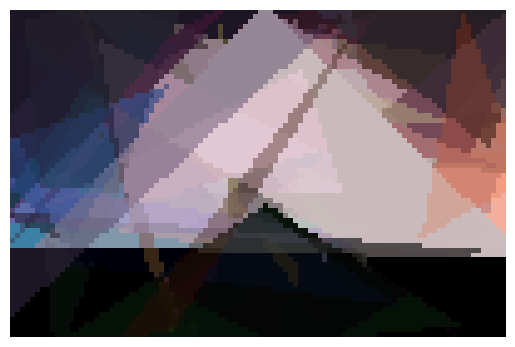

Fitness in Generation 1910: mean: -275.30898823529407, max: -274.90749711649363 min: -276.54917339484814
Fitness in Generation 1920: mean: -274.7175101883891, max: -274.5701806997309 min: -274.8335563244906
Fitness in Generation 1930: mean: -274.3971540176855, max: -274.10665128796614 min: -274.49277970011536
Fitness in Generation 1940: mean: -274.00111464821225, max: -273.999446366782 min: -274.00118415993853
Fitness in Generation 1950: mean: -273.6393568627451, max: -273.5131718569781 min: -273.9214302191465
Fitness in Generation 1960: mean: -273.1312541330258, max: -273.0110572856594 min: -273.1892349096501
Fitness in Generation 1970: mean: -272.85532395232605, max: -272.77966935793927 min: -272.94217608612075
Fitness in Generation 1980: mean: -272.4680987312572, max: -272.34885044213763 min: -272.6149480968858
Fitness in Generation 1990: mean: -272.0590105344099, max: -271.5569242599001 min: -272.2775701653211
Fitness in Generation 2000: mean: -271.3843586312957, max: -270.99449442

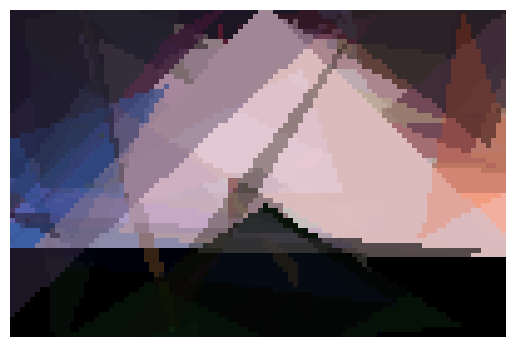

Fitness in Generation 2010: mean: -270.92898054594394, max: -270.67207996924265 min: -270.98985005767014
Fitness in Generation 2020: mean: -268.98631449442524, max: -268.11706266820454 min: -270.63718569780855
Fitness in Generation 2030: mean: -268.00206166858896, max: -267.83706266820457 min: -268.0692656670511
Fitness in Generation 2040: mean: -267.63398877354865, max: -267.41919261822375 min: -267.76076893502506
Fitness in Generation 2050: mean: -267.03533194925035, max: -266.8079969242599 min: -267.1414686658977
Fitness in Generation 2060: mean: -266.3115287966167, max: -266.1127566320646 min: -266.42688196847365
Fitness in Generation 2070: mean: -265.88457239523257, max: -265.7923260284506 min: -265.9489734717416
Fitness in Generation 2080: mean: -259.4704239907728, max: -253.1020376778162 min: -265.76572087658593
Fitness in Generation 2090: mean: -252.93692302960392, max: -252.49851595540176 min: -253.04882737408687
Fitness in Generation 2100: mean: -252.2035823144945, max: -251.

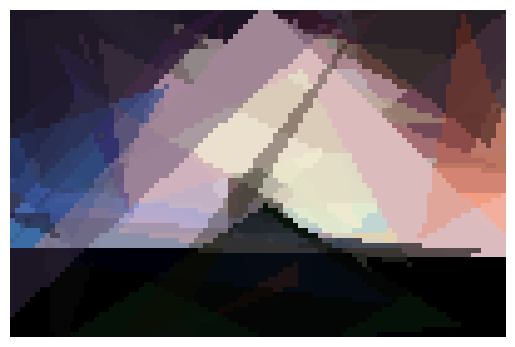

Fitness in Generation 2110: mean: -250.4425171856978, max: -237.40907343329488 min: -251.3608765859285
Fitness in Generation 2120: mean: -236.35542945021146, max: -234.77051903114187 min: -237.4058592848904
Fitness in Generation 2130: mean: -234.52050965013458, max: -234.24958093041135 min: -234.5279507881584
Fitness in Generation 2140: mean: -230.83537562475973, max: -229.46617454825068 min: -231.3415916955017
Fitness in Generation 2150: mean: -228.5102517493272, max: -228.1736409073433 min: -228.90849673202615
Fitness in Generation 2160: mean: -227.9584424452134, max: -227.82477508650518 min: -228.1736409073433
Fitness in Generation 2170: mean: -225.5860838139177, max: -225.3173394848135 min: -226.57848519800075
Fitness in Generation 2180: mean: -224.6407947712418, max: -224.50294502114573 min: -225.1806228373702
Fitness in Generation 2190: mean: -224.35788911956936, max: -224.2527950788158 min: -224.42343713956168
Fitness in Generation 2200: mean: -224.0172247597078, max: -223.79540

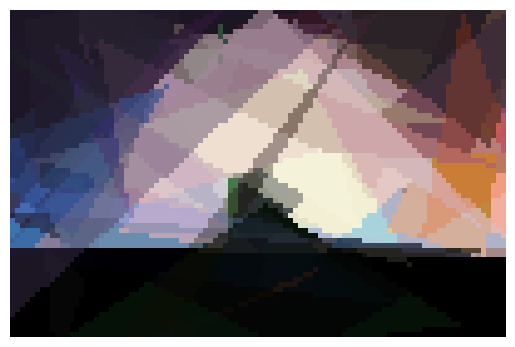

Fitness in Generation 2210: mean: -223.47343052672048, max: -223.04059976931947 min: -223.65093425605536
Fitness in Generation 2220: mean: -222.7928590542099, max: -222.4712187620146 min: -222.9754402153018
Fitness in Generation 2230: mean: -221.85488965782395, max: -220.7032064590542 min: -222.4712802768166
Fitness in Generation 2240: mean: -219.35215286428294, max: -218.9908958093041 min: -219.51512495194157
Fitness in Generation 2250: mean: -218.73944913494807, max: -218.06994232987313 min: -218.9054363706267
Fitness in Generation 2260: mean: -217.64659746251448, max: -217.28676662821994 min: -218.06855824682816
Fitness in Generation 2270: mean: -217.10944529027296, max: -217.09404075355633 min: -217.11649365628605
Fitness in Generation 2280: mean: -216.96712095347942, max: -216.68407535563247 min: -217.09308727412534
Fitness in Generation 2290: mean: -216.50947235678584, max: -216.47860053825454 min: -216.5343790849673
Fitness in Generation 2300: mean: -215.81127873894656, max: -21

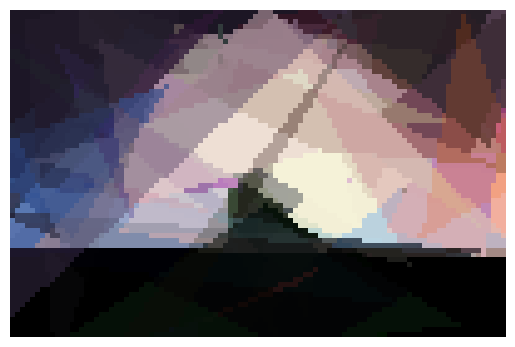

Fitness in Generation 2310: mean: -212.8057996155325, max: -211.67063437139564 min: -213.26735870818914
Fitness in Generation 2320: mean: -210.97410257593233, max: -210.7253825451749 min: -211.49048827374088
Fitness in Generation 2330: mean: -210.00799723183394, max: -209.38720492118415 min: -210.7253825451749
Fitness in Generation 2340: mean: -208.94605459438674, max: -207.52784313725488 min: -209.38720492118415
Fitness in Generation 2350: mean: -207.2679655517109, max: -207.0501191849289 min: -207.45351787773933
Fitness in Generation 2360: mean: -206.46609919261823, max: -203.70582083813918 min: -207.0501191849289
Fitness in Generation 2370: mean: -203.50822883506345, max: -203.14823529411765 min: -203.70331410995772
Fitness in Generation 2380: mean: -202.81618085351786, max: -202.77178008458284 min: -202.8236370626682
Fitness in Generation 2390: mean: -202.5176405997693, max: -202.14991157247215 min: -202.65316416762784
Fitness in Generation 2400: mean: -202.05194063821602, max: -20

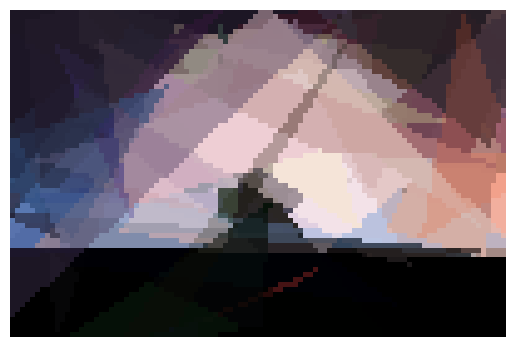

Fitness in Generation 2410: mean: -201.7893730103806, max: -200.91281814686658 min: -201.85304113802383
Fitness in Generation 2420: mean: -200.3209150326797, max: -198.958892733564 min: -200.81734717416376
Fitness in Generation 2430: mean: -198.79896778162242, max: -198.72564398308342 min: -198.82508266051516
Fitness in Generation 2440: mean: -198.42755770857357, max: -198.19863129565553 min: -198.58029988465972
Fitness in Generation 2450: mean: -197.721539100346, max: -196.9743790849673 min: -197.97926951172624
Fitness in Generation 2460: mean: -195.28405351787777, max: -194.15075740099962 min: -196.68026143790848
Fitness in Generation 2470: mean: -193.61238077662435, max: -193.33787004998078 min: -193.75535563244904
Fitness in Generation 2480: mean: -193.24267189542488, max: -193.03360246059208 min: -193.27537101114956
Fitness in Generation 2490: mean: -192.37895455594003, max: -191.51574009996156 min: -193.0245905420992
Fitness in Generation 2500: mean: -190.8497387158785, max: -190

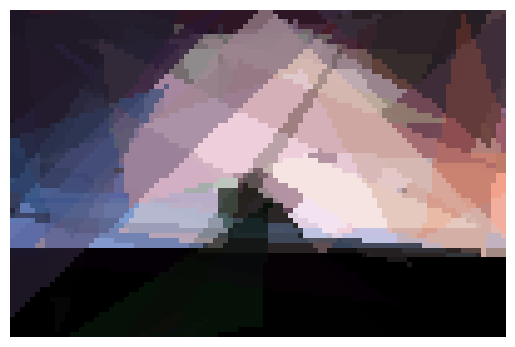

Fitness in Generation 2510: mean: -190.04441091887736, max: -189.9046828143022 min: -190.20216839677047
Fitness in Generation 2520: mean: -189.7019106497501, max: -189.5101268742791 min: -189.79486351403307
Fitness in Generation 2530: mean: -189.34814825067278, max: -189.25940792003075 min: -189.4625297962322
Fitness in Generation 2540: mean: -189.0608953479431, max: -188.96647443291042 min: -189.14572856593617
Fitness in Generation 2550: mean: -188.68817777777775, max: -188.57221068819683 min: -188.7263975394079
Fitness in Generation 2560: mean: -188.3857165705498, max: -188.27938485197998 min: -188.54103806228375
Fitness in Generation 2570: mean: -184.11021237985392, max: -184.05064206074587 min: -184.121045751634
Fitness in Generation 2580: mean: -183.6596976547482, max: -183.2712341407151 min: -183.8943329488658
Fitness in Generation 2590: mean: -182.93000968858138, max: -182.7838677431757 min: -183.01367166474432
Fitness in Generation 2600: mean: -182.59279630911186, max: -182.317

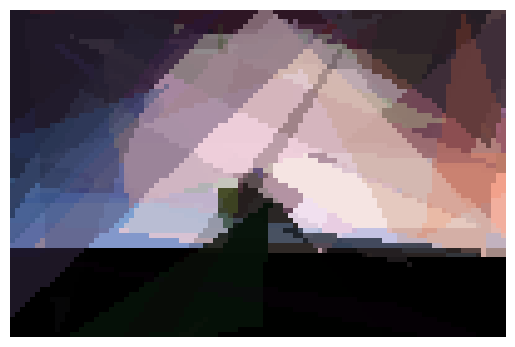

Fitness in Generation 2610: mean: -182.0973465590158, max: -181.82274509803923 min: -182.21114955786234
Fitness in Generation 2620: mean: -181.64917739331028, max: -181.35415609381008 min: -181.82274509803923
Fitness in Generation 2630: mean: -181.15091826220686, max: -181.08241445597847 min: -181.22252979623224
Fitness in Generation 2640: mean: -180.48760169165706, max: -180.08464436755096 min: -180.7376701268743
Fitness in Generation 2650: mean: -179.7833716262976, max: -179.60201460976546 min: -180.09547097270283
Fitness in Generation 2660: mean: -179.29246905036524, max: -179.02240676662822 min: -179.41896193771626
Fitness in Generation 2670: mean: -178.7845803921568, max: -178.6948865820838 min: -179.02240676662822
Fitness in Generation 2680: mean: -178.53722414455981, max: -177.5848519800077 min: -178.64249134948093
Fitness in Generation 2690: mean: -177.56273525567087, max: -177.4651903114187 min: -177.5848519800077
Fitness in Generation 2700: mean: -177.1645284121492, max: -176

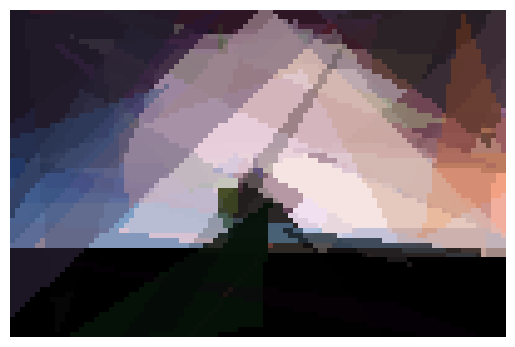

Fitness in Generation 2710: mean: -176.6274383698578, max: -176.58302191464824 min: -176.63572472126106
Fitness in Generation 2720: mean: -176.5142569780854, max: -176.482276047674 min: -176.5389926951173
Fitness in Generation 2730: mean: -176.4585445597847, max: -176.4501960784314 min: -176.482276047674
Fitness in Generation 2740: mean: -176.1958520569012, max: -175.522245290273 min: -176.4501960784314
Fitness in Generation 2750: mean: -174.97401184159943, max: -174.87641676278352 min: -175.0169165705498
Fitness in Generation 2760: mean: -174.7346706651288, max: -174.281322568243 min: -174.86111495578623
Fitness in Generation 2770: mean: -174.0438563629373, max: -173.64979623221836 min: -174.1756247597078
Fitness in Generation 2780: mean: -173.38684813533254, max: -173.3273356401384 min: -173.397477893118
Fitness in Generation 2790: mean: -172.8536898116109, max: -172.39460207612458 min: -173.30952710495964
Fitness in Generation 2800: mean: -172.30167166474436, max: -172.2032756632064

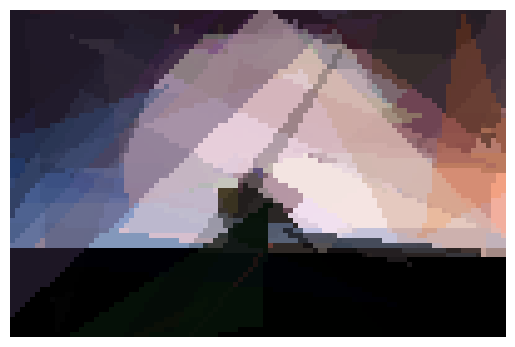

Fitness in Generation 2810: mean: -172.17636509034986, max: -172.1171395617071 min: -172.20327566320648
Fitness in Generation 2820: mean: -171.95309004229148, max: -171.8165782391388 min: -172.1171395617071
Fitness in Generation 2830: mean: -171.7940638216071, max: -171.75464821222607 min: -171.8165782391388
Fitness in Generation 2840: mean: -171.64306589773165, max: -171.3713956170704 min: -171.75464821222607
Fitness in Generation 2850: mean: -171.28325259515572, max: -171.24839677047288 min: -171.28505959246445
Fitness in Generation 2860: mean: -171.17173794694344, max: -167.43944636678202 min: -171.24839677047288
Fitness in Generation 2870: mean: -167.43833787004993, max: -167.42552864282968 min: -167.43944636678202
Fitness in Generation 2880: mean: -166.94440138408302, max: -166.78615916955016 min: -167.2964552095348
Fitness in Generation 2890: mean: -166.57015978469818, max: -166.559661668589 min: -166.57437908496732
Fitness in Generation 2900: mean: -166.53165705497887, max: -166

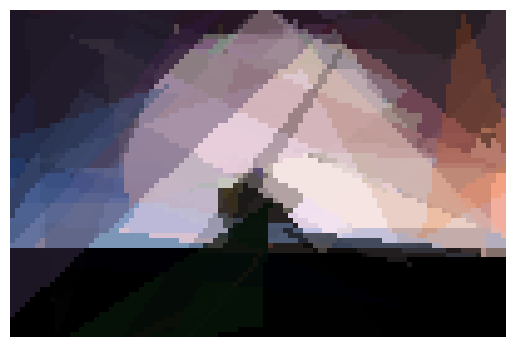

Fitness in Generation 2910: mean: -166.3510093041138, max: -166.34557477893117 min: -166.38096116878125
Fitness in Generation 2920: mean: -166.30780745866974, max: -166.26869665513263 min: -166.31981545559398
Fitness in Generation 2930: mean: -166.23387989234908, max: -166.15767781622452 min: -166.24315263360245
Fitness in Generation 2940: mean: -165.99994186851214, max: -165.37747020376779 min: -166.14583621683968
Fitness in Generation 2950: mean: -165.3219786236063, max: -165.22229911572472 min: -165.37747020376779
Fitness in Generation 2960: mean: -164.91991880046132, max: -164.63344867358705 min: -164.96187620146097
Fitness in Generation 2970: mean: -164.37065128796618, max: -164.30629757785468 min: -164.4862437524029
Fitness in Generation 2980: mean: -163.81276370626682, max: -163.71443291041908 min: -163.92338331410997
Fitness in Generation 2990: mean: -163.54998508266047, max: -163.5128796616686 min: -163.58632833525567
Fitness in Generation 3000: mean: -163.45445659361783, max:

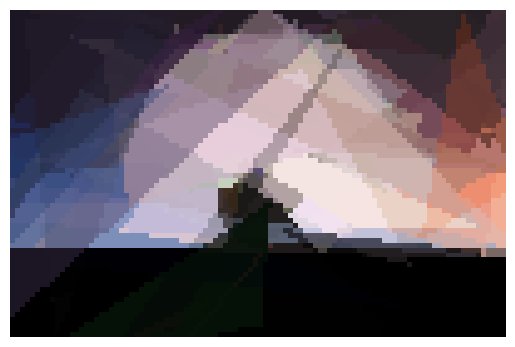

Fitness in Generation 3010: mean: -163.36142591311034, max: -163.32249134948097 min: -163.38228373702418
Fitness in Generation 3020: mean: -163.264306958862, max: -163.1024529027297 min: -163.30789696270665
Fitness in Generation 3030: mean: -162.75750434448287, max: -162.56858131487888 min: -163.08795078815837
Fitness in Generation 3040: mean: -162.52567227989232, max: -162.4708958093041 min: -162.53048827374087
Fitness in Generation 3050: mean: -162.4566997308727, max: -162.26448289119568 min: -162.4708958093041
Fitness in Generation 3060: mean: -162.24041553248748, max: -162.20146097654745 min: -162.69770088427526
Fitness in Generation 3070: mean: -162.09455255670895, max: -161.97467128027682 min: -162.13098039215686
Fitness in Generation 3080: mean: -161.9535507881584, max: -161.92981161091885 min: -161.97138023836985
Fitness in Generation 3090: mean: -160.80673986928102, max: -159.97653210303727 min: -161.92206074586696
Fitness in Generation 3100: mean: -159.9235970780469, max: -15

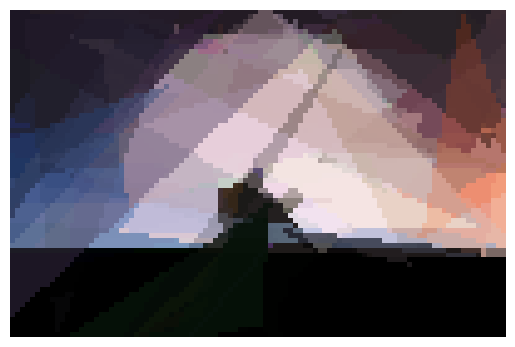

Fitness in Generation 3110: mean: -159.532830757401, max: -159.52256824298345 min: -159.70160707420223
Fitness in Generation 3120: mean: -159.19295470972702, max: -159.0486889657824 min: -159.52256824298345
Fitness in Generation 3130: mean: -158.9812838139177, max: -158.89082660515183 min: -158.98809688581315
Fitness in Generation 3140: mean: -158.78052472126103, max: -158.67001922337562 min: -158.8477047289504
Fitness in Generation 3150: mean: -158.63133440984234, max: -158.61371780084585 min: -158.638185313341
Fitness in Generation 3160: mean: -158.5432559784698, max: -157.93187235678585 min: -158.61371780084585
Fitness in Generation 3170: mean: -157.87805551710883, max: -157.85399461745482 min: -157.8973164167628
Fitness in Generation 3180: mean: -157.78782622068437, max: -157.57034986543638 min: -157.85399461745482
Fitness in Generation 3190: mean: -157.54261499423302, max: -157.4564244521338 min: -157.57034986543638
Fitness in Generation 3200: mean: -157.42353956170703, max: -157.

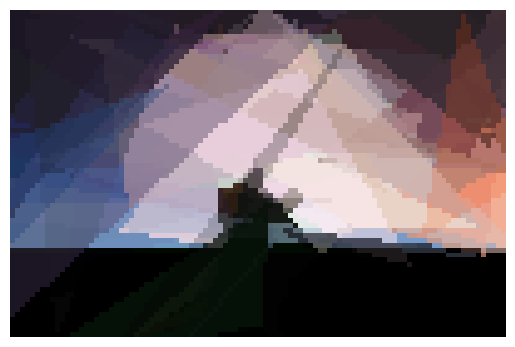

Fitness in Generation 3210: mean: -157.23760369088816, max: -157.18133025759326 min: -157.37267204921184
Fitness in Generation 3220: mean: -156.59913694732796, max: -155.42615916955017 min: -157.10394463667822
Fitness in Generation 3230: mean: -154.22484367550942, max: -154.09988465974627 min: -154.32701268742792
Fitness in Generation 3240: mean: -154.00757277970013, max: -153.91669357939253 min: -154.03340253748559
Fitness in Generation 3250: mean: -153.68218838908112, max: -153.29894655901577 min: -153.84628988850443
Fitness in Generation 3260: mean: -153.02381114955784, max: -152.91638600538252 min: -153.2965013456363
Fitness in Generation 3270: mean: -152.91501299500186, max: -152.90222222222224 min: -152.91638600538252
Fitness in Generation 3280: mean: -152.79412779700115, max: -152.74992695117263 min: -152.90222222222224
Fitness in Generation 3290: mean: -152.66486612841217, max: -152.6078585159554 min: -152.74992695117263
Fitness in Generation 3300: mean: -152.51888565936179, ma

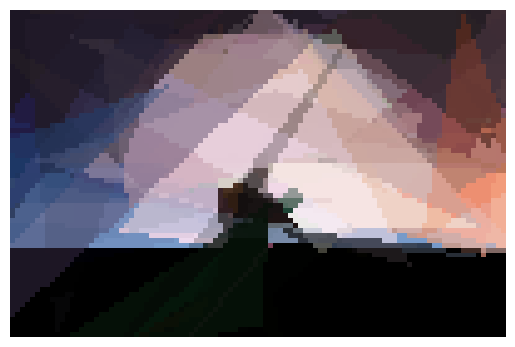

Fitness in Generation 3310: mean: -152.36801199538638, max: -152.31798539023453 min: -152.62682045367168
Fitness in Generation 3320: mean: -151.6006339100346, max: -150.88681276432138 min: -152.1771318723568
Fitness in Generation 3330: mean: -150.88521122645133, max: -150.86834294502114 min: -150.88681276432138
Fitness in Generation 3340: mean: -150.82932133794696, max: -150.74242214532873 min: -150.83833910034602
Fitness in Generation 3350: mean: -150.525322568243, max: -150.41607074202233 min: -150.6556862745098
Fitness in Generation 3360: mean: -149.83184590542098, max: -149.8310495963091 min: -149.83644752018452
Fitness in Generation 3370: mean: -149.49128796616685, max: -149.03613994617456 min: -149.64124567474047
Fitness in Generation 3380: mean: -148.6624126105344, max: -148.6313110342176 min: -148.68184544405997
Fitness in Generation 3390: mean: -148.48365520953476, max: -148.40455209534795 min: -148.51567858515952
Fitness in Generation 3400: mean: -148.33981514802, max: -148.2

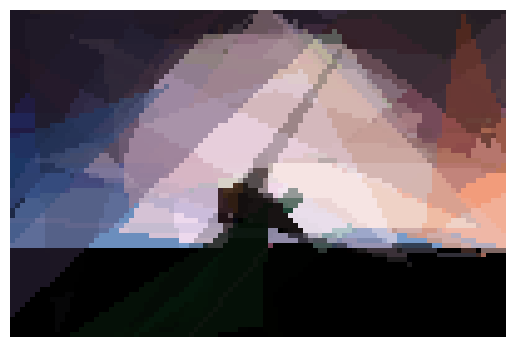

Fitness in Generation 3410: mean: -148.03524429065746, max: -147.9678123798539 min: -148.12330642060743
Fitness in Generation 3420: mean: -147.85669696270665, max: -147.84227604767398 min: -147.91795463283353
Fitness in Generation 3430: mean: -147.74783237216457, max: -147.53504036908882 min: -147.77894655901576
Fitness in Generation 3440: mean: -147.3861597846982, max: -147.38160707420224 min: -147.38755863129566
Fitness in Generation 3450: mean: -147.1748361399462, max: -147.04504421376396 min: -147.38091503267975
Fitness in Generation 3460: mean: -146.96823221837755, max: -146.8259284890427 min: -147.03835447904652
Fitness in Generation 3470: mean: -146.8300364475202, max: -146.77178008458287 min: -146.8969011918493
Fitness in Generation 3480: mean: -146.76306282199155, max: -146.75104959630912 min: -146.77178008458287
Fitness in Generation 3490: mean: -146.62726828143022, max: -146.06220684352172 min: -146.74855824682817
Fitness in Generation 3500: mean: -146.03100592079969, max: -

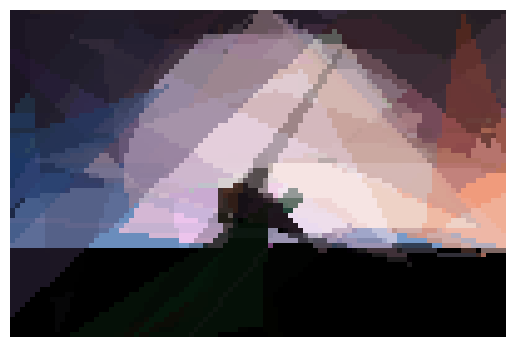

Fitness in Generation 3510: mean: -145.94861730103804, max: -145.93966935793924 min: -145.95786236063051
Fitness in Generation 3520: mean: -145.9387635524798, max: -145.93061130334485 min: -145.93966935793924
Fitness in Generation 3530: mean: -145.64065790080738, max: -144.08392156862743 min: -145.92361399461745
Fitness in Generation 3540: mean: -144.05945313341022, max: -144.03004998077662 min: -144.08392156862743
Fitness in Generation 3550: mean: -143.88107497116494, max: -143.7752556708958 min: -143.93081122645134
Fitness in Generation 3560: mean: -143.62183529411763, max: -143.4218685121107 min: -143.7400384467512
Fitness in Generation 3570: mean: -143.1147195693964, max: -143.11003460207613 min: -143.1665667051134
Fitness in Generation 3580: mean: -143.0560882737408, max: -143.03955401768548 min: -143.11003460207613
Fitness in Generation 3590: mean: -142.8575969242599, max: -142.84416762783542 min: -142.89371780084582
Fitness in Generation 3600: mean: -142.67855071126488, max: -14

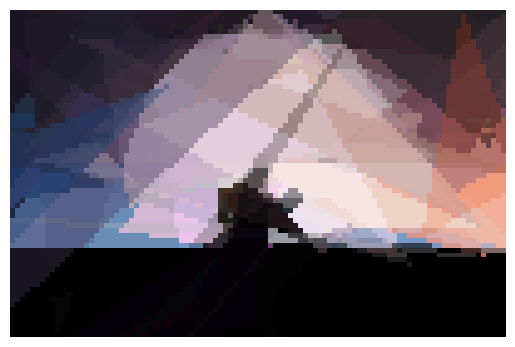

Fitness in Generation 3610: mean: -142.61978377547092, max: -142.59996924259897 min: -142.65600922722027
Fitness in Generation 3620: mean: -142.57968135332564, max: -142.54928104575163 min: -142.59996924259897
Fitness in Generation 3630: mean: -142.50866036139945, max: -142.2161014994233 min: -142.56118415993848
Fitness in Generation 3640: mean: -142.17556078431372, max: -142.1051595540177 min: -142.18589773164166
Fitness in Generation 3650: mean: -141.97514648212223, max: -141.79750865051903 min: -142.1051595540177
Fitness in Generation 3660: mean: -141.10798400615147, max: -140.6080123029604 min: -141.72602845059592
Fitness in Generation 3670: mean: -140.60091134179163, max: -140.48412149173396 min: -140.6080123029604
Fitness in Generation 3680: mean: -140.46684106113037, max: -140.35644752018456 min: -140.48412149173396
Fitness in Generation 3690: mean: -140.2418020761246, max: -140.02219146482122 min: -140.35644752018456
Fitness in Generation 3700: mean: -139.39357385620917, max: -

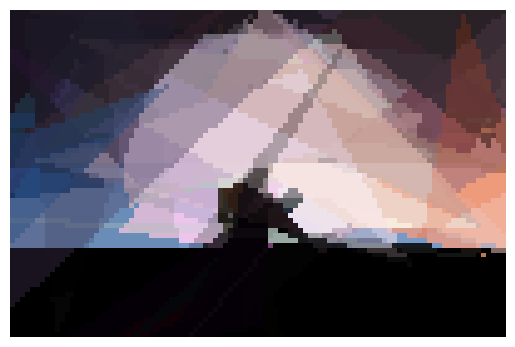

Fitness in Generation 3710: mean: -139.1488387543253, max: -139.05259515570935 min: -139.29427143406383
Fitness in Generation 3720: mean: -138.94320092272204, max: -138.92366013071896 min: -139.00682814302192
Fitness in Generation 3730: mean: -138.77103175701654, max: -138.17044213763938 min: -138.92366013071896
Fitness in Generation 3740: mean: -138.11307620146098, max: -138.0483044982699 min: -138.1353787004998
Fitness in Generation 3750: mean: -137.8157437908497, max: -137.6099500192234 min: -138.0483044982699
Fitness in Generation 3760: mean: -137.53838615916956, max: -137.479846212995 min: -137.5746405228758
Fitness in Generation 3770: mean: -137.30969042675895, max: -137.23329488658212 min: -137.439200307574
Fitness in Generation 3780: mean: -136.33831726259132, max: -136.2722337562476 min: -136.38643598615917
Fitness in Generation 3790: mean: -136.23499823144945, max: -136.2145174932718 min: -136.26940407535565
Fitness in Generation 3800: mean: -136.19674186851208, max: -136.178

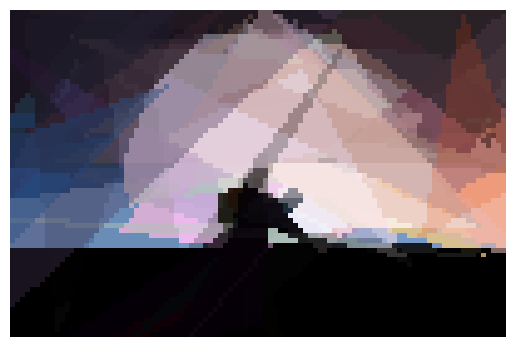

Fitness in Generation 3810: mean: -136.1371352556709, max: -136.09084198385236 min: -136.17865436370627
Fitness in Generation 3820: mean: -135.91474294502115, max: -135.74737408688966 min: -135.95378700499808
Fitness in Generation 3830: mean: -135.64893502499038, max: -135.61184159938486 min: -135.71068050749713
Fitness in Generation 3840: mean: -135.57270649750095, max: -135.3851134179162 min: -135.5819607843137
Fitness in Generation 3850: mean: -135.38437216455205, max: -135.3740407535563 min: -135.3851134179162
Fitness in Generation 3860: mean: -135.32246089965395, max: -135.0250826605152 min: -135.3740407535563
Fitness in Generation 3870: mean: -134.8682974240677, max: -134.65708573625528 min: -134.97453287197234
Fitness in Generation 3880: mean: -133.78071234140714, max: -132.48301422529795 min: -134.118031526336
Fitness in Generation 3890: mean: -132.23966105344095, max: -132.0583929257978 min: -132.3269511726259
Fitness in Generation 3900: mean: -132.03519200307576, max: -131.80

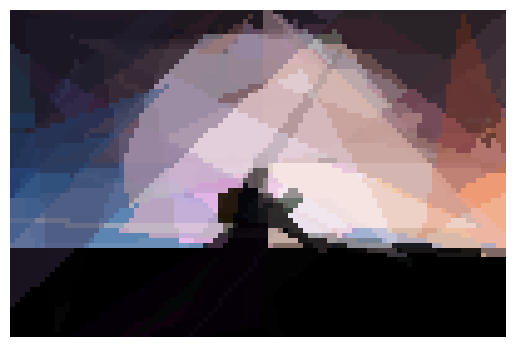

Fitness in Generation 3910: mean: -131.7664895040369, max: -131.7530488273741 min: -131.7681353325644
Fitness in Generation 3920: mean: -131.7039160322953, max: -131.58985005767013 min: -131.7382083813918
Fitness in Generation 3930: mean: -131.5553617839293, max: -131.34752787389468 min: -131.561076509035
Fitness in Generation 3940: mean: -131.25526981930028, max: -131.22256055363323 min: -131.29474817377934
Fitness in Generation 3950: mean: -131.19619315647827, max: -131.13287197231836 min: -131.22256055363323
Fitness in Generation 3960: mean: -131.07367966166862, max: -130.7684275278739 min: -131.11057285659365
Fitness in Generation 3970: mean: -130.82157078046907, max: -130.72662821991543 min: -131.0482429834679
Fitness in Generation 3980: mean: -130.6816550557478, max: -130.62925028835065 min: -130.71151095732412
Fitness in Generation 3990: mean: -130.56266205305653, max: -130.51850826605153 min: -130.61299500192234
Fitness in Generation 4000: mean: -130.33548019992313, max: -130.2

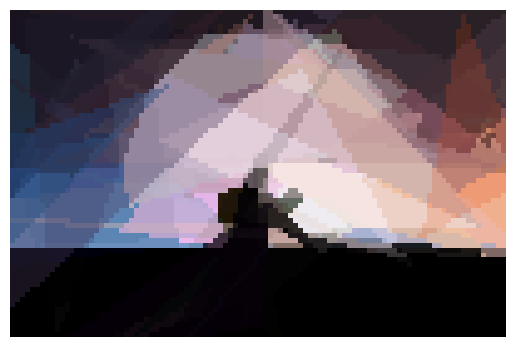

Fitness in Generation 4010: mean: -130.22216132256824, max: -130.13313341022683 min: -130.25111880046134
Fitness in Generation 4020: mean: -129.96674294502114, max: -129.78580545943868 min: -130.1272587466359
Fitness in Generation 4030: mean: -129.6999292579777, max: -129.57136485966933 min: -129.78396001537868
Fitness in Generation 4040: mean: -129.47028681276433, max: -128.31721645520952 min: -129.53493271818527
Fitness in Generation 4050: mean: -128.26694471357172, max: -128.17756247597077 min: -128.2876893502499
Fitness in Generation 4060: mean: -128.12393387158784, max: -128.07103421760863 min: -128.14803537101116
Fitness in Generation 4070: mean: -128.0220825836217, max: -127.95175701653211 min: -128.06861976163012
Fitness in Generation 4080: mean: -127.90051149557861, max: -127.77217993079586 min: -127.95175701653211
Fitness in Generation 4090: mean: -127.62598323721646, max: -127.50595924644367 min: -127.65857747020377
Fitness in Generation 4100: mean: -127.46138777393311, max:

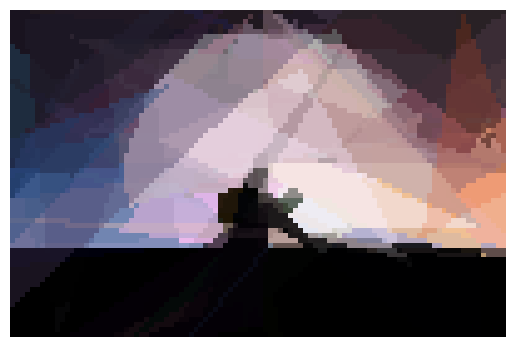

Fitness in Generation 4110: mean: -127.36995124951937, max: -127.36850442137639 min: -127.37022683583237
Fitness in Generation 4120: mean: -127.3574308342945, max: -127.3290580545944 min: -127.36850442137639
Fitness in Generation 4130: mean: -127.3269468665898, max: -127.32665897731643 min: -127.3290580545944
Fitness in Generation 4140: mean: -127.19827912341407, max: -124.5117877739331 min: -127.32069204152249
Fitness in Generation 4150: mean: -124.49918000768936, max: -124.479138792772 min: -124.50952710495962
Fitness in Generation 4160: mean: -124.24604475201848, max: -122.93125720876586 min: -124.45902345251827
Fitness in Generation 4170: mean: -122.7009691657055, max: -122.38017685505575 min: -122.90920415224915
Fitness in Generation 4180: mean: -122.24701053440985, max: -121.61697808535179 min: -122.38017685505575
Fitness in Generation 4190: mean: -121.48612195309495, max: -121.41854671280277 min: -121.61697808535179
Fitness in Generation 4200: mean: -121.3490918877355, max: -121

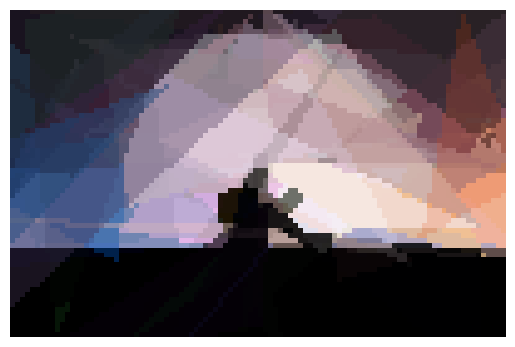

Fitness in Generation 4210: mean: -121.17760123029606, max: -121.0628681276432 min: -121.22405228758169
Fitness in Generation 4220: mean: -120.97154048442906, max: -120.83286428296807 min: -120.98648212226065
Fitness in Generation 4230: mean: -120.79498100730488, max: -120.74363706266818 min: -120.83286428296807
Fitness in Generation 4240: mean: -120.63761384083045, max: -120.59630911188003 min: -120.69388696655132
Fitness in Generation 4250: mean: -120.42854317570168, max: -120.34657439446367 min: -120.56833525567089
Fitness in Generation 4260: mean: -120.19250134563629, max: -119.94835832372164 min: -120.34657439446367
Fitness in Generation 4270: mean: -119.92565321030372, max: -119.75258746635909 min: -119.94131487889273
Fitness in Generation 4280: mean: -119.66874063821608, max: -119.56947327950789 min: -119.75258746635909
Fitness in Generation 4290: mean: -119.56490857362553, max: -119.49339484813532 min: -119.56947327950789
Fitness in Generation 4300: mean: -119.2970023836986, ma

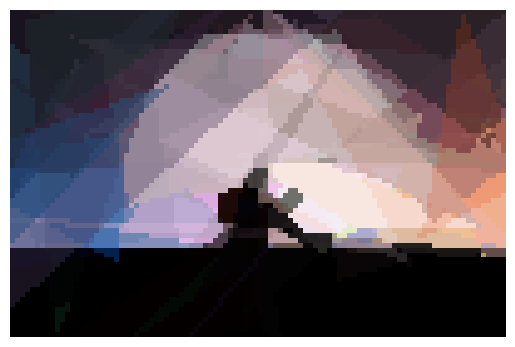

Fitness in Generation 4310: mean: -117.85992525951555, max: -117.85130334486735 min: -117.86929642445213
Fitness in Generation 4320: mean: -117.74263252595154, max: -117.39574009996156 min: -117.759507881584
Fitness in Generation 4330: mean: -117.30359769319492, max: -117.26988081507115 min: -117.33185697808533
Fitness in Generation 4340: mean: -117.2570706651288, max: -117.23735486351403 min: -117.26988081507115
Fitness in Generation 4350: mean: -117.16598815840061, max: -117.09154940407537 min: -117.23735486351403
Fitness in Generation 4360: mean: -117.08734794309879, max: -117.08335255670896 min: -117.0875201845444
Fitness in Generation 4370: mean: -116.99756093810072, max: -116.93302575932334 min: -117.08335255670896
Fitness in Generation 4380: mean: -116.83881491733948, max: -116.82851211072662 min: -116.90283737024222
Fitness in Generation 4390: mean: -116.75571610918877, max: -116.74222222222222 min: -116.82851211072662
Fitness in Generation 4400: mean: -116.3355635524798, max: 

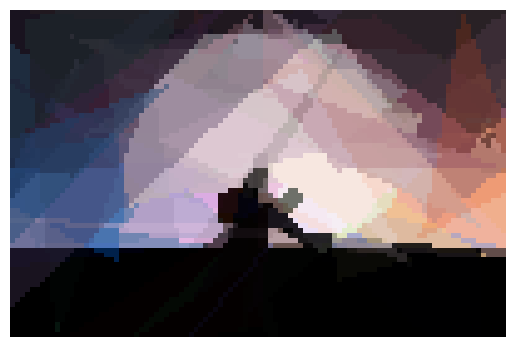

Fitness in Generation 4410: mean: -116.14766628219917, max: -116.14766628219917 min: -116.14766628219917
Fitness in Generation 4420: mean: -116.14434602076126, max: -116.10239138792774 min: -116.14766628219917
Fitness in Generation 4430: mean: -116.048276509035, max: -116.02488273740869 min: -116.10239138792774
Fitness in Generation 4440: mean: -115.97786082276049, max: -115.93611687812378 min: -116.00582852748944
Fitness in Generation 4450: mean: -115.92030941945404, max: -115.87154171472511 min: -115.93611687812378
Fitness in Generation 4460: mean: -115.84216655132643, max: -115.82491349480969 min: -115.85239523260284
Fitness in Generation 4470: mean: -115.57565151864668, max: -115.49866974240676 min: -115.81022683583237
Fitness in Generation 4480: mean: -115.49866974240675, max: -115.49866974240676 min: -115.49866974240676
Fitness in Generation 4490: mean: -115.4558339100346, max: -115.25936178392925 min: -115.49727028066127
Fitness in Generation 4500: mean: -115.25853871587853, max

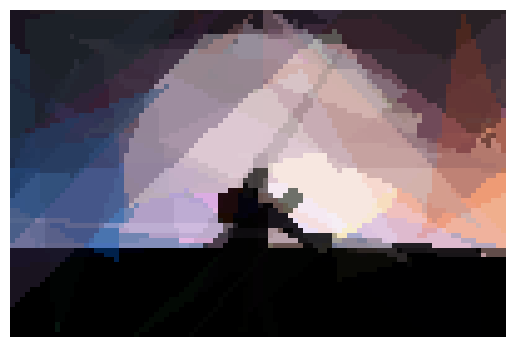

Fitness in Generation 4510: mean: -115.2452093810073, max: -115.05587081891579 min: -115.24907343329488
Fitness in Generation 4520: mean: -115.01852518262203, max: -115.00593617839291 min: -115.05587081891579
Fitness in Generation 4530: mean: -114.9542791234141, max: -114.9518646674356 min: -115.00442906574395
Fitness in Generation 4540: mean: -114.93461591695502, max: -114.93030372933487 min: -114.9518646674356
Fitness in Generation 4550: mean: -114.83933594771243, max: -114.83301806997308 min: -114.84072279892348
Fitness in Generation 4560: mean: -114.30067820069202, max: -114.19449442522108 min: -114.31263360246058
Fitness in Generation 4570: mean: -114.17198462129953, max: -113.75152633602461 min: -114.19449442522108
Fitness in Generation 4580: mean: -113.7049928489043, max: -113.62646674356016 min: -113.72167627835448
Fitness in Generation 4590: mean: -113.59959246443672, max: -113.53070357554786 min: -113.60931949250288
Fitness in Generation 4600: mean: -113.50941207227989, max: 

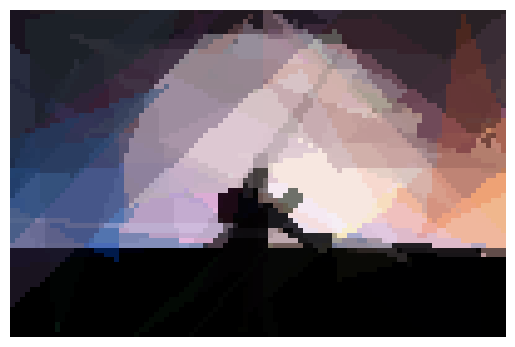

Fitness in Generation 4610: mean: -113.46248304498273, max: -113.22957324106112 min: -113.4721876201461
Fitness in Generation 4620: mean: -113.20583836985774, max: -112.99321799307957 min: -113.22957324106112
Fitness in Generation 4630: mean: -112.86521368704342, max: -112.8073817762399 min: -112.99321799307957
Fitness in Generation 4640: mean: -112.77055040369086, max: -112.68525951557092 min: -112.8073817762399
Fitness in Generation 4650: mean: -112.68476616685886, max: -112.68347558631295 min: -112.68525951557092
Fitness in Generation 4660: mean: -112.40318154555938, max: -112.37350249903884 min: -112.40919646289888
Fitness in Generation 4670: mean: -112.36834417531722, max: -112.35956939638601 min: -112.37350249903884
Fitness in Generation 4680: mean: -112.35288581314877, max: -112.34234525182622 min: -112.35380238369856
Fitness in Generation 4690: mean: -112.3373628604383, max: -112.32641291810842 min: -112.33797770088427
Fitness in Generation 4700: mean: -112.32598508266052, max:

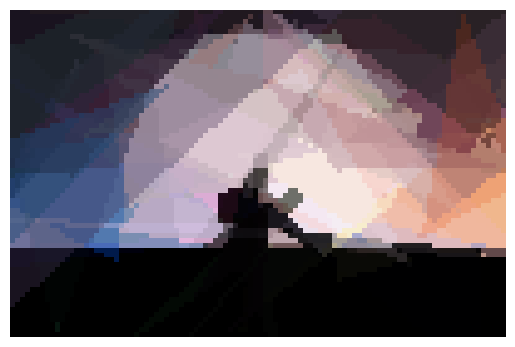

Fitness in Generation 4710: mean: -112.30254086889657, max: -111.53697808535178 min: -112.32596693579393
Fitness in Generation 4720: mean: -111.50959723183388, max: -111.44519800076894 min: -111.53697808535178
Fitness in Generation 4730: mean: -111.24053856209152, max: -110.0101806997309 min: -111.44519800076894
Fitness in Generation 4740: mean: -109.70028173779316, max: -109.35383314109957 min: -110.0101806997309
Fitness in Generation 4750: mean: -109.29986405228757, max: -109.23683198769704 min: -109.34798923490963
Fitness in Generation 4760: mean: -109.22537239523263, max: -109.2160553633218 min: -109.22782006920416
Fitness in Generation 4770: mean: -108.98774225297963, max: -108.7763475586313 min: -109.21021145713186
Fitness in Generation 4780: mean: -108.77611687812383, max: -108.77442522106882 min: -108.7763475586313
Fitness in Generation 4790: mean: -108.72176485966936, max: -108.65041138023837 min: -108.77442522106882
Fitness in Generation 4800: mean: -108.64907896962706, max: 

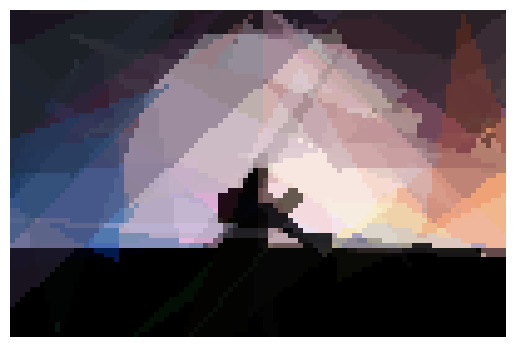

Fitness in Generation 4810: mean: -108.6320184544406, max: -108.59724721261051 min: -108.64636678200692
Fitness in Generation 4820: mean: -108.5972472126105, max: -108.59724721261051 min: -108.59724721261051
Fitness in Generation 4830: mean: -108.56918569780852, max: -107.76913494809688 min: -108.58552864282967
Fitness in Generation 4840: mean: -107.76030634371392, max: -107.64030757400998 min: -107.76913494809688
Fitness in Generation 4850: mean: -107.35713371780085, max: -106.52133794694348 min: -107.63953863898499
Fitness in Generation 4860: mean: -106.45314079200307, max: -106.41960784313724 min: -106.52133794694348
Fitness in Generation 4870: mean: -106.41960784313721, max: -106.41960784313724 min: -106.41960784313724
Fitness in Generation 4880: mean: -106.41893671664741, max: -106.39346405228758 min: -106.41960784313724
Fitness in Generation 4890: mean: -106.35314755863128, max: -106.31638600538254 min: -106.39346405228758
Fitness in Generation 4900: mean: -106.2478554402153, max

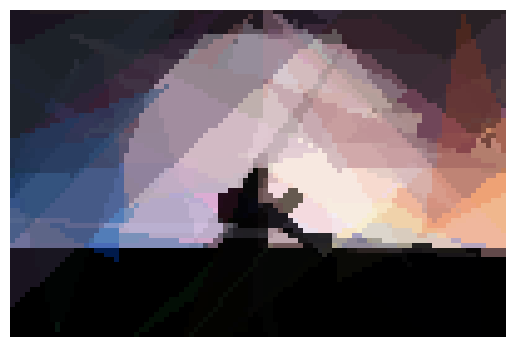

Fitness in Generation 4910: mean: -106.19496655132642, max: -106.18771241830063 min: -106.19600153787005
Fitness in Generation 4920: mean: -106.18755740099961, max: -106.18577470203766 min: -106.18771241830063
Fitness in Generation 4930: mean: -105.65067527873894, max: -104.77150326797386 min: -106.17230296039983
Fitness in Generation 4940: mean: -104.7623055747789, max: -104.74960399846213 min: -104.77150326797386
Fitness in Generation 4950: mean: -104.64640799692427, max: -104.59630911188005 min: -104.66754325259515
Fitness in Generation 4960: mean: -104.58332425990004, max: -104.54775855440217 min: -104.59630911188005
Fitness in Generation 4970: mean: -104.54048442906577, max: -104.45607074202229 min: -104.54775855440217
Fitness in Generation 4980: mean: -104.32423529411768, max: -104.27012687427914 min: -104.32648981161093
Fitness in Generation 4990: mean: -104.26994909650136, max: -104.26123798539024 min: -104.27012687427914
Fitness in Generation 5000: mean: -104.25378177623992, m

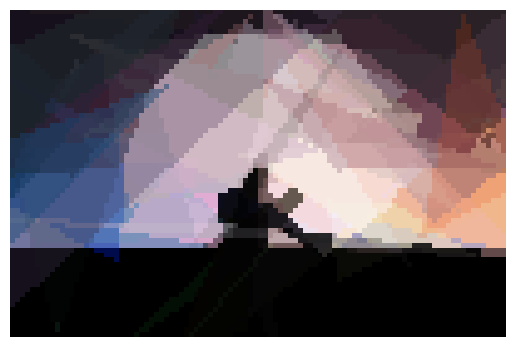

Fitness in Generation 5010: mean: -104.24144867358707, max: -104.20901191849289 min: -104.35132641291811
Fitness in Generation 5020: mean: -104.19747789311805, max: -104.18594386774318 min: -104.20901191849289
Fitness in Generation 5030: mean: -104.18487043444827, max: -104.15910803537102 min: -104.18594386774318
Fitness in Generation 5040: mean: -104.14671618608227, max: -104.02941945405613 min: -104.15910803537102
Fitness in Generation 5050: mean: -103.83713771626299, max: -103.78988081507113 min: -103.96788927335642
Fitness in Generation 5060: mean: -103.78456224529029, max: -103.75510957324107 min: -103.78757400999616
Fitness in Generation 5070: mean: -103.7472141484045, max: -103.73242599000385 min: -103.75510957324107
Fitness in Generation 5080: mean: -103.71237985390239, max: -103.69091887735487 min: -103.73242599000385
Fitness in Generation 5090: mean: -103.67798539023451, max: -103.67798539023453 min: -103.67798539023453
Fitness in Generation 5100: mean: -103.64194386774318, m

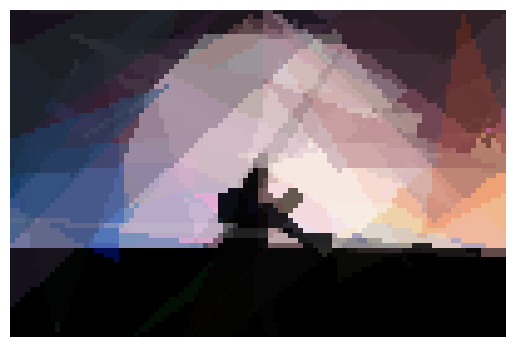

Fitness in Generation 5110: mean: -103.43232664359863, max: -103.41730103806229 min: -103.45903883121876
Fitness in Generation 5120: mean: -103.41730103806226, max: -103.41730103806229 min: -103.41730103806229
Fitness in Generation 5130: mean: -103.41588988850442, max: -103.39454056132256 min: -103.41730103806229
Fitness in Generation 5140: mean: -103.38944498269895, max: -103.35088043060361 min: -103.39454056132256
Fitness in Generation 5150: mean: -103.3497731641676, max: -103.34977316416762 min: -103.34977316416762
Fitness in Generation 5160: mean: -103.32779546328332, max: -103.31432525951557 min: -103.34977316416762
Fitness in Generation 5170: mean: -103.31432525951557, max: -103.31432525951557 min: -103.31432525951557
Fitness in Generation 5180: mean: -103.30595801614763, max: -103.30165321030373 min: -103.31432525951557
Fitness in Generation 5190: mean: -103.28678385236448, max: -103.05905420991927 min: -103.29150326797385
Fitness in Generation 5200: mean: -103.04575778546712, m

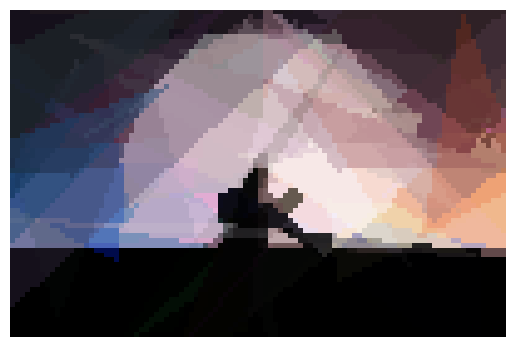

Fitness in Generation 5210: mean: -102.91812379853901, max: -102.880738177624 min: -102.93897731641677
Fitness in Generation 5220: mean: -102.84436539792388, max: -102.7831449442522 min: -102.85274894271434
Fitness in Generation 5230: mean: -102.7810559015763, max: -102.76819684736641 min: -102.78159169550173
Fitness in Generation 5240: mean: -102.6876346020761, max: -102.66153018069973 min: -102.76819684736641
Fitness in Generation 5250: mean: -102.5888522875817, max: -102.51900038446752 min: -102.66494425221067
Fitness in Generation 5260: mean: -102.32365767012689, max: -102.27804690503652 min: -102.50671280276816
Fitness in Generation 5270: mean: -100.03135655517107, max: -100.00564398308342 min: -100.05096501345636
Fitness in Generation 5280: mean: -100.00564398308342, max: -100.00564398308342 min: -100.00564398308342
Fitness in Generation 5290: mean: -99.99287258746634, max: -99.88064590542099 min: -100.00564398308342
Fitness in Generation 5300: mean: -99.845077739331, max: -99.81

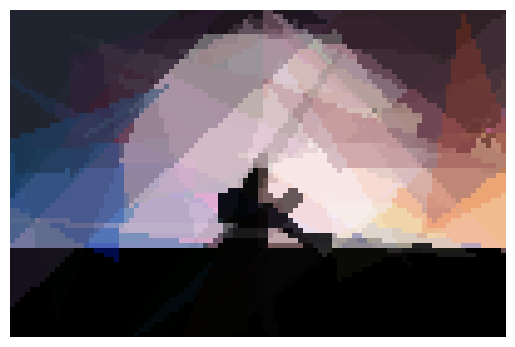

Fitness in Generation 5310: mean: -99.7325939254133, max: -99.72390618992695 min: -99.74935793925414
Fitness in Generation 5320: mean: -98.84131518646674, max: -98.518800461361 min: -99.6480738177624
Fitness in Generation 5330: mean: -98.51692856593618, max: -98.51604767397154 min: -98.518800461361
Fitness in Generation 5340: mean: -98.51483029603997, max: -98.51060361399462 min: -98.51604767397154
Fitness in Generation 5350: mean: -98.50774778931182, max: -98.49282583621684 min: -98.51060361399462
Fitness in Generation 5360: mean: -98.48299915417148, max: -98.46492887351019 min: -98.49039600153786
Fitness in Generation 5370: mean: -98.46132841214916, max: -98.45894655901576 min: -98.46492887351019
Fitness in Generation 5380: mean: -98.45894655901577, max: -98.45894655901576 min: -98.45894655901576
Fitness in Generation 5390: mean: -98.45423760092274, max: -98.44831987697039 min: -98.45894655901576
Fitness in Generation 5400: mean: -98.4479876970396, max: -98.44790465205689 min: -98.44

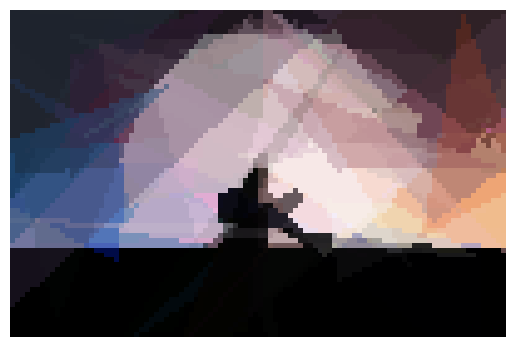

Fitness in Generation 5410: mean: -98.44234309880817, max: -98.38145328719723 min: -98.44790465205689
Fitness in Generation 5420: mean: -98.36330642060747, max: -98.36330642060746 min: -98.36330642060746
Fitness in Generation 5430: mean: -97.5295175701653, max: -97.51324875048059 min: -97.53010380622837
Fitness in Generation 5440: mean: -97.50576516724337, max: -97.48978085351789 min: -97.51324875048059
Fitness in Generation 5450: mean: -97.48751926182238, max: -97.48304498269896 min: -97.48978085351789
Fitness in Generation 5460: mean: -97.46292287581699, max: -97.44373702422145 min: -97.48738177623991
Fitness in Generation 5470: mean: -97.1638957324106, max: -97.13405613225683 min: -97.44373702422145
Fitness in Generation 5480: mean: -97.1251967704729, max: -97.11450980392156 min: -97.13405613225683
Fitness in Generation 5490: mean: -97.11017301038062, max: -97.1101730103806 min: -97.1101730103806
Fitness in Generation 5500: mean: -97.09382329873125, max: -97.07480199923106 min: -97.

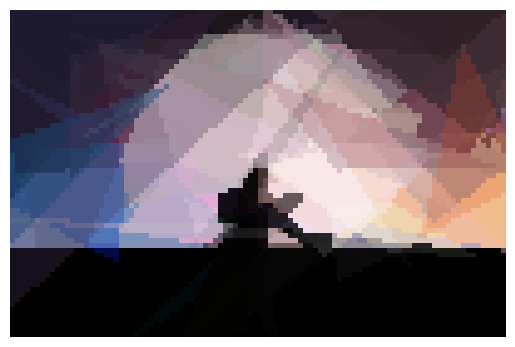

Fitness in Generation 5510: mean: -97.04215363321796, max: -97.03446366782008 min: -97.04412149173393
Fitness in Generation 5520: mean: -97.02720707420224, max: -97.0074740484429 min: -97.0312802768166
Fitness in Generation 5530: mean: -97.00076001537869, max: -96.94971164936561 min: -97.00393694732794
Fitness in Generation 5540: mean: -96.89885367166477, max: -96.8717570165321 min: -96.94720492118415
Fitness in Generation 5550: mean: -96.87175701653209, max: -96.8717570165321 min: -96.8717570165321
Fitness in Generation 5560: mean: -96.76039738562089, max: -95.69264129181083 min: -96.8717570165321
Fitness in Generation 5570: mean: -95.66566366782008, max: -95.66056132256823 min: -95.66831218762015
Fitness in Generation 5580: mean: -95.58682506728182, max: -95.439446366782 min: -95.66056132256823
Fitness in Generation 5590: mean: -95.36446166858899, max: -95.35755478662051 min: -95.36855055747789
Fitness in Generation 5600: mean: -95.3416956555171, max: -95.31617070357554 min: -95.3536

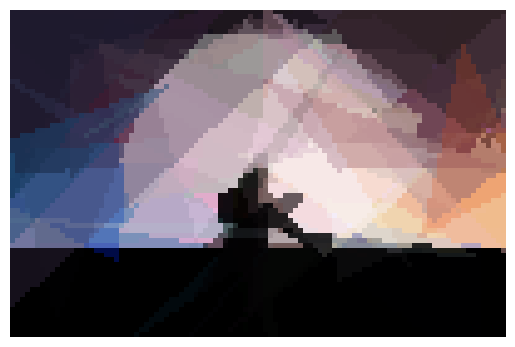

Fitness in Generation 5610: mean: -95.31309742406764, max: -95.24164552095347 min: -95.31617070357554
Fitness in Generation 5620: mean: -95.14060530565165, max: -95.04518262206844 min: -95.24010765090348
Fitness in Generation 5630: mean: -95.03634048442908, max: -94.73773164167628 min: -95.04518262206844
Fitness in Generation 5640: mean: -94.71023237216454, max: -94.70783544790464 min: -94.73773164167628
Fitness in Generation 5650: mean: -94.65131872356785, max: -94.65131872356785 min: -94.65131872356785
Fitness in Generation 5660: mean: -94.65118585159554, max: -94.64799692425989 min: -94.65131872356785
Fitness in Generation 5670: mean: -94.6218743560169, max: -94.60942714340638 min: -94.64416762783544
Fitness in Generation 5680: mean: -94.3147724721261, max: -94.30852748942715 min: -94.31757016532104
Fitness in Generation 5690: mean: -94.3014397539408, max: -94.29779315647828 min: -94.30159169550173
Fitness in Generation 5700: mean: -94.29696916570549, max: -94.28399846212994 min: -9

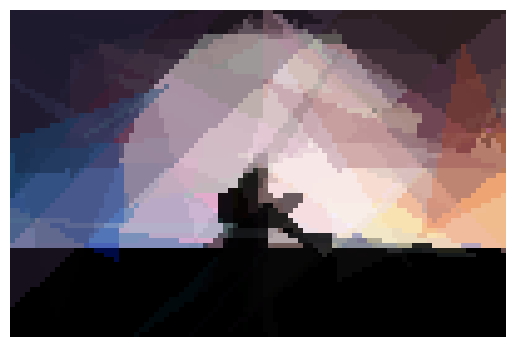

Fitness in Generation 5710: mean: -94.27820192233754, max: -94.27667820069205 min: -94.28247597078047
Fitness in Generation 5720: mean: -94.26916539792386, max: -94.24315263360246 min: -94.27667820069205
Fitness in Generation 5730: mean: -94.18695609381008, max: -94.1679046520569 min: -94.24129181084199
Fitness in Generation 5740: mean: -94.16789419454055, max: -94.1676432141484 min: -94.1679046520569
Fitness in Generation 5750: mean: -94.1664744329104, max: -94.16647443291042 min: -94.16647443291042
Fitness in Generation 5760: mean: -94.16065297962321, max: -94.09956170703576 min: -94.16647443291042
Fitness in Generation 5770: mean: -94.09959523260284, max: -94.09956170703576 min: -94.10123798539023
Fitness in Generation 5780: mean: -94.09933164167629, max: -94.09668589004228 min: -94.09956170703576
Fitness in Generation 5790: mean: -94.08078985005767, max: -94.07998462129949 min: -94.08286043829297
Fitness in Generation 5800: mean: -93.9919138792772, max: -93.98855824682813 min: -93.

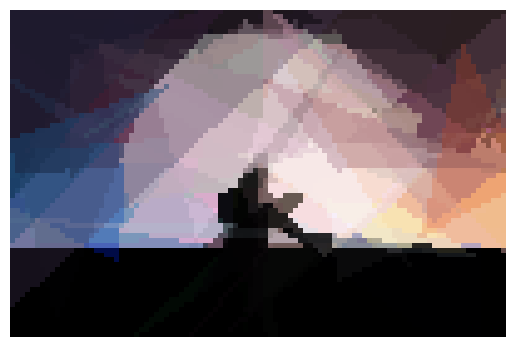

Fitness in Generation 5810: mean: -93.98127612456744, max: -93.97690119184928 min: -93.98855824682813
Fitness in Generation 5820: mean: -93.9727600153787, max: -93.92513648596693 min: -93.97690119184928
Fitness in Generation 5830: mean: -93.92507128027681, max: -93.92322952710497 min: -93.92513648596693
Fitness in Generation 5840: mean: -93.91730965013456, max: -93.88356785851595 min: -93.92322952710497
Fitness in Generation 5850: mean: -93.80783883121875, max: -93.80378316032294 min: -93.82688196847364
Fitness in Generation 5860: mean: -93.80091380238372, max: -93.79561707035755 min: -93.80378316032294
Fitness in Generation 5870: mean: -93.78759492502881, max: -93.71004998077663 min: -93.79486351403305
Fitness in Generation 5880: mean: -93.70867143406383, max: -93.7050519031142 min: -93.71004998077663
Fitness in Generation 5890: mean: -93.7011103421761, max: -93.70056132256823 min: -93.70186851211072
Fitness in Generation 5900: mean: -93.5542988081507, max: -93.48778162245289 min: -93

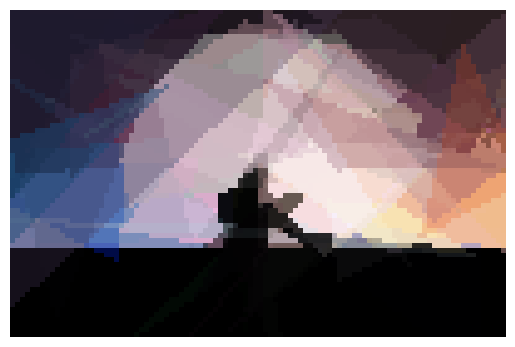

Fitness in Generation 5910: mean: -93.47958046905035, max: -93.43594002306803 min: -93.48778162245289
Fitness in Generation 5920: mean: -93.41691287966165, max: -93.3992156862745 min: -93.43294117647058
Fitness in Generation 5930: mean: -93.39921568627449, max: -93.3992156862745 min: -93.3992156862745
Fitness in Generation 5940: mean: -93.32596416762784, max: -93.3032372164552 min: -93.38837370242213
Fitness in Generation 5950: mean: -93.28709388696655, max: -93.238954248366 min: -93.30801999231063
Fitness in Generation 5960: mean: -93.21114094579008, max: -93.16132256824298 min: -93.238954248366
Fitness in Generation 5970: mean: -93.15060853517876, max: -93.1120030757401 min: -93.16132256824298
Fitness in Generation 5980: mean: -93.10663068050748, max: -93.1032064590542 min: -93.1120030757401
Fitness in Generation 5990: mean: -93.10320645905422, max: -93.1032064590542 min: -93.1032064590542
Fitness in Generation 6000: mean: -93.08459607843139, max: -93.03884659746251 min: -93.10320645

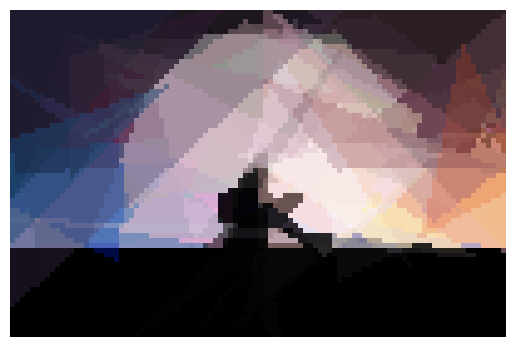

Fitness in Generation 6010: mean: -93.01647151095735, max: -92.9598000768935 min: -93.03884659746251
Fitness in Generation 6020: mean: -92.96101776239908, max: -92.95767781622452 min: -93.07586312956556
Fitness in Generation 6030: mean: -92.93249519415609, max: -92.83604767397154 min: -92.95767781622452
Fitness in Generation 6040: mean: -92.79360184544404, max: -91.7749019607843 min: -92.83604767397154
Fitness in Generation 6050: mean: -91.77490196078432, max: -91.7749019607843 min: -91.7749019607843
Fitness in Generation 6060: mean: -91.74616747404843, max: -91.73164167627834 min: -91.7749019607843
Fitness in Generation 6070: mean: -91.63629680891965, max: -91.54188389081122 min: -91.73164167627834
Fitness in Generation 6080: mean: -91.5194688196847, max: -91.50185313341022 min: -91.54188389081122
Fitness in Generation 6090: mean: -91.49621991541711, max: -91.4398615916955 min: -91.50185313341022
Fitness in Generation 6100: mean: -91.41999630911185, max: -91.41819300269127 min: -91.42

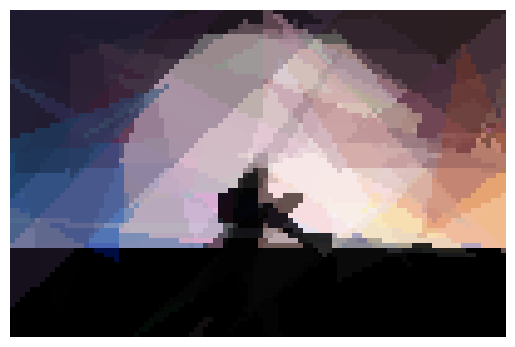

Fitness in Generation 6110: mean: -91.41408504421378, max: -91.32395232602843 min: -91.41819300269127
Fitness in Generation 6120: mean: -91.32090734332945, max: -91.31549404075353 min: -91.32395232602843
Fitness in Generation 6130: mean: -91.30733902345251, max: -91.15137254901961 min: -91.31549404075353
Fitness in Generation 6140: mean: -91.14386435986158, max: -91.13636293733181 min: -91.15137254901961
Fitness in Generation 6150: mean: -91.10646551326414, max: -91.04758169934641 min: -91.13636293733181
Fitness in Generation 6160: mean: -91.03984744329108, max: -91.02609765474817 min: -91.04758169934641
Fitness in Generation 6170: mean: -91.02609765474816, max: -91.02609765474817 min: -91.02609765474817
Fitness in Generation 6180: mean: -91.0220342945021, max: -91.0161168781238 min: -91.02609765474817
Fitness in Generation 6190: mean: -91.01154940407535, max: -91.01154940407534 min: -91.01154940407534
Fitness in Generation 6200: mean: -91.00990388312188, max: -91.00332179930797 min: -

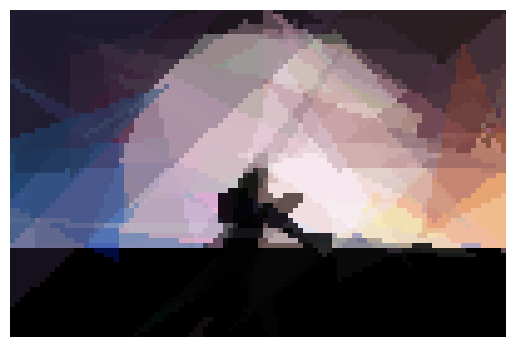

Fitness in Generation 6210: mean: -91.00157354863514, max: -90.99717031910804 min: -91.00332179930797
Fitness in Generation 6220: mean: -90.98455363321798, max: -90.98153018069974 min: -90.99377162629759
Fitness in Generation 6230: mean: -90.9670557477893, max: -90.96227604767397 min: -90.97813148788927
Fitness in Generation 6240: mean: -90.96009473279508, max: -90.9350096116878 min: -90.96227604767397
Fitness in Generation 6250: mean: -90.9350096116878, max: -90.9350096116878 min: -90.9350096116878
Fitness in Generation 6260: mean: -90.9338220684352, max: -90.88507497116493 min: -90.9350096116878
Fitness in Generation 6270: mean: -90.88613241061128, max: -90.83115724721259 min: -90.93431757016532
Fitness in Generation 6280: mean: -90.8304652056901, max: -90.8304652056901 min: -90.8304652056901
Fitness in Generation 6290: mean: -90.80748112264511, max: -90.8070742022299 min: -90.81385620915032
Fitness in Generation 6300: mean: -90.8070742022299, max: -90.8070742022299 min: -90.80707420

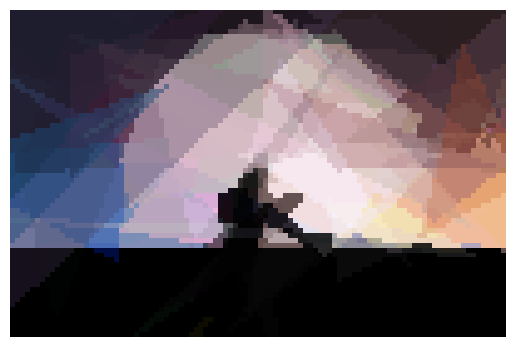

Fitness in Generation 6310: mean: -90.73200399846213, max: -90.71011149557862 min: -90.8070742022299
Fitness in Generation 6320: mean: -90.70481814686659, max: -90.70257593233372 min: -90.71011149557862
Fitness in Generation 6330: mean: -90.67401553248746, max: -90.41928489042675 min: -90.69616301422528
Fitness in Generation 6340: mean: -90.41593048827373, max: -90.3754094579008 min: -90.41928489042675
Fitness in Generation 6350: mean: -90.32822975778546, max: -90.29819300269126 min: -90.3754094579008
Fitness in Generation 6360: mean: -90.2981394848135, max: -90.29685505574778 min: -90.29819300269126
Fitness in Generation 6370: mean: -90.29685505574778, max: -90.29685505574778 min: -90.29685505574778
Fitness in Generation 6380: mean: -90.29685505574778, max: -90.29685505574778 min: -90.29685505574778
Fitness in Generation 6390: mean: -90.2886557477893, max: -90.27377162629757 min: -90.29685505574778
Fitness in Generation 6400: mean: -90.26770934256052, max: -90.25959246443675 min: -90.

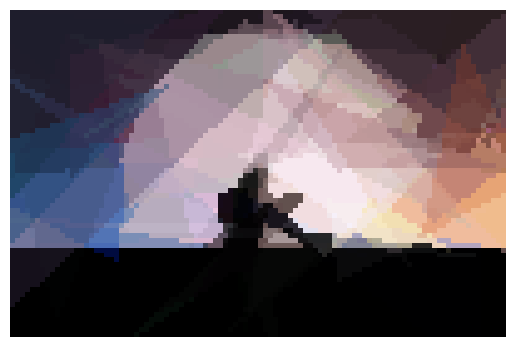

Fitness in Generation 6410: mean: -90.23067281814684, max: -90.19595540176854 min: -90.25959246443675
Fitness in Generation 6420: mean: -90.18937178008458, max: -90.18754325259515 min: -90.19595540176854
Fitness in Generation 6430: mean: -90.14713787004996, max: -90.08910419069588 min: -90.18754325259515
Fitness in Generation 6440: mean: -90.08910419069589, max: -90.08910419069588 min: -90.08910419069588
Fitness in Generation 6450: mean: -90.08906266820453, max: -90.08868896578238 min: -90.08910419069588
Fitness in Generation 6460: mean: -90.08868896578237, max: -90.08868896578238 min: -90.08868896578238
Fitness in Generation 6470: mean: -90.08868896578237, max: -90.08868896578238 min: -90.08868896578238
Fitness in Generation 6480: mean: -90.08779976931946, max: -90.04422914263743 min: -90.08868896578238
Fitness in Generation 6490: mean: -90.04422914263742, max: -90.04422914263743 min: -90.04422914263743
Fitness in Generation 6500: mean: -89.98452072279892, max: -89.88258362168398 min:

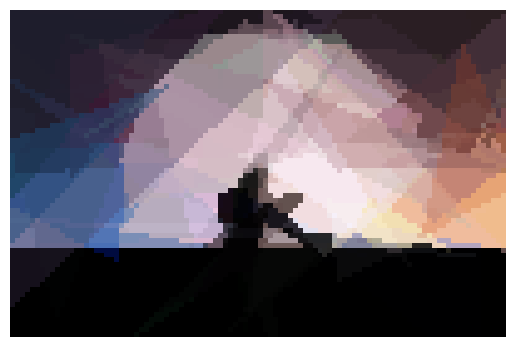

Fitness in Generation 6510: mean: -89.75420007689348, max: -89.70451364859667 min: -89.88258362168398
Fitness in Generation 6520: mean: -89.70305697808533, max: -89.69654748173781 min: -89.70451364859667
Fitness in Generation 6530: mean: -88.96045182622066, max: -88.92216839677047 min: -89.68513648596695
Fitness in Generation 6540: mean: -88.9000793540946, max: -88.840492118416 min: -88.92216839677047
Fitness in Generation 6550: mean: -88.81411180315263, max: -88.79704728950404 min: -88.840492118416
Fitness in Generation 6560: mean: -88.76125397923876, max: -88.74357554786621 min: -88.76161476355247
Fitness in Generation 6570: mean: -88.73885121107269, max: -88.72782775855441 min: -88.74357554786621
Fitness in Generation 6580: mean: -88.71297839292582, max: -88.70835832372164 min: -88.72782775855441
Fitness in Generation 6590: mean: -88.69085920799692, max: -88.69031910803537 min: -88.70835832372164
Fitness in Generation 6600: mean: -88.65411088043062, max: -88.64159938485199 min: -88.

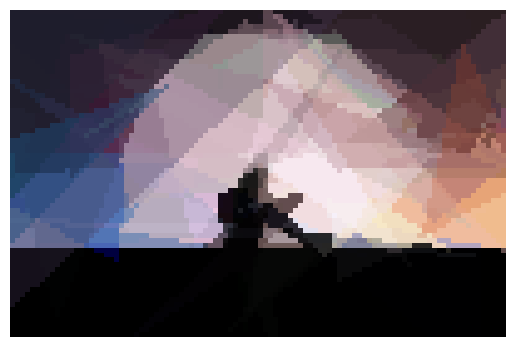

Fitness in Generation 6610: mean: -88.6364456747405, max: -88.62143790849673 min: -88.64159938485199
Fitness in Generation 6620: mean: -88.61737547097269, max: -88.5916339869281 min: -88.62143790849673
Fitness in Generation 6630: mean: -88.209354248366, max: -87.66735870818916 min: -88.5916339869281
Fitness in Generation 6640: mean: -87.65907820069204, max: -87.65750096116876 min: -87.66735870818916
Fitness in Generation 6650: mean: -87.58497193387157, max: -87.53979238754324 min: -87.65750096116876
Fitness in Generation 6660: mean: -87.51986620530566, max: -87.50119184928873 min: -87.53979238754324
Fitness in Generation 6670: mean: -87.40755801614763, max: -87.399046520569 min: -87.50119184928873
Fitness in Generation 6680: mean: -87.39904652056899, max: -87.399046520569 min: -87.399046520569
Fitness in Generation 6690: mean: -87.38749650134561, max: -87.29393310265282 min: -87.399046520569
Fitness in Generation 6700: mean: -87.26672664359863, max: -87.2643137254902 min: -87.272356785

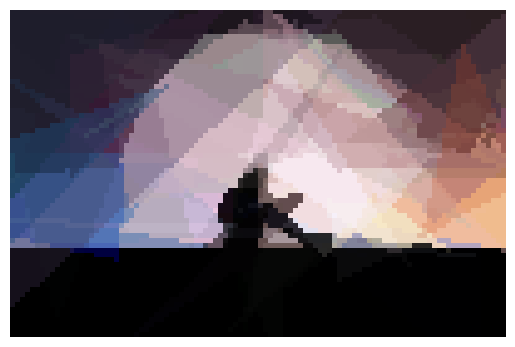

Fitness in Generation 6710: mean: -86.65338592848904, max: -86.55518646674356 min: -87.2643137254902
Fitness in Generation 6720: mean: -86.55030680507494, max: -86.54234525182622 min: -86.55518646674356
Fitness in Generation 6730: mean: -86.41264867358706, max: -86.39021914648211 min: -86.42146866589772
Fitness in Generation 6740: mean: -86.39021914648211, max: -86.39021914648211 min: -86.39021914648211
Fitness in Generation 6750: mean: -86.36369088811996, max: -86.31673971549404 min: -86.37133410226835
Fitness in Generation 6760: mean: -86.25903175701653, max: -86.24196847366396 min: -86.31673971549404
Fitness in Generation 6770: mean: -86.20802399077279, max: -86.20384467512494 min: -86.20824298346788
Fitness in Generation 6780: mean: -86.19151495578622, max: -86.17790080738177 min: -86.20384467512494
Fitness in Generation 6790: mean: -86.17718354479048, max: -86.1770857362553 min: -86.17790080738177
Fitness in Generation 6800: mean: -86.17695747789314, max: -86.1749480968858 min: -8

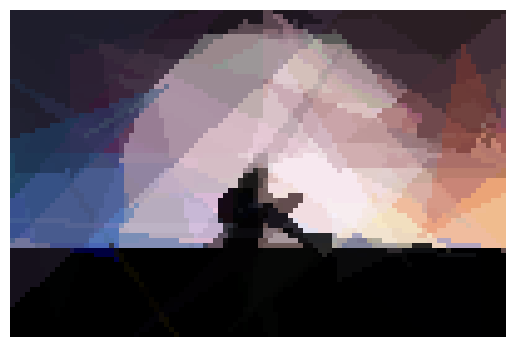

Fitness in Generation 6810: mean: -86.17653364090735, max: -86.1678277585544 min: -86.26500576701268
Fitness in Generation 6820: mean: -86.15556970396003, max: -86.14459054209918 min: -86.1678277585544
Fitness in Generation 6830: mean: -86.14459054209915, max: -86.14459054209918 min: -86.14459054209918
Fitness in Generation 6840: mean: -86.06476555171085, max: -85.9912495194156 min: -86.14459054209918
Fitness in Generation 6850: mean: -85.94076124567474, max: -85.7832525951557 min: -85.99037293348711
Fitness in Generation 6860: mean: -85.77811672433678, max: -85.74565167243368 min: -85.7832525951557
Fitness in Generation 6870: mean: -85.72987681660899, max: -85.71529411764705 min: -85.74565167243368
Fitness in Generation 6880: mean: -85.71421545559399, max: -85.7049442522107 min: -85.71800076893503
Fitness in Generation 6890: mean: -85.69866851211074, max: -85.69671664744328 min: -85.7049442522107
Fitness in Generation 6900: mean: -85.38256116878124, max: -85.12990388312187 min: -85.46

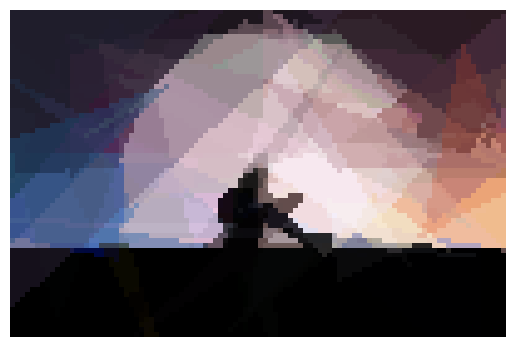

Fitness in Generation 6910: mean: -85.12990388312188, max: -85.12990388312187 min: -85.12990388312187
Fitness in Generation 6920: mean: -85.12924567474049, max: -85.12167627835447 min: -85.12990388312187
Fitness in Generation 6930: mean: -85.1215910803537, max: -85.11741637831602 min: -85.12167627835447
Fitness in Generation 6940: mean: -85.11569088811996, max: -85.10657439446366 min: -85.11741637831602
Fitness in Generation 6950: mean: -84.9968959630911, max: -84.51816993464053 min: -85.08778162245288
Fitness in Generation 6960: mean: -84.49820838139178, max: -84.4964552095348 min: -84.49937716262977
Fitness in Generation 6970: mean: -84.49623437139562, max: -84.49093425605537 min: -84.4964552095348
Fitness in Generation 6980: mean: -84.49093425605535, max: -84.49093425605537 min: -84.49093425605537
Fitness in Generation 6990: mean: -84.31861653210302, max: -84.2556708958093 min: -84.49093425605537
Fitness in Generation 7000: mean: -84.1838985005767, max: -84.1838985005767 min: -84.18

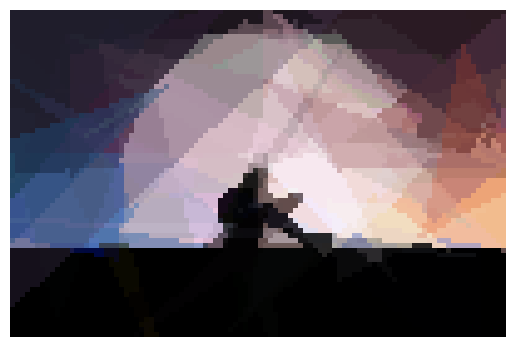

Fitness in Generation 7010: mean: -84.18012395232603, max: -84.1685198000769 min: -84.1838985005767
Fitness in Generation 7020: mean: -84.1475509419454, max: -84.08530565167243 min: -84.16222991157247
Fitness in Generation 7030: mean: -84.04416516724338, max: -83.96784313725489 min: -84.06011534025374
Fitness in Generation 7040: mean: -83.94945082660513, max: -83.92469050365244 min: -83.96784313725489
Fitness in Generation 7050: mean: -83.91103975394078, max: -83.90718954248365 min: -83.92469050365244
Fitness in Generation 7060: mean: -83.85263052672049, max: -83.52212226066898 min: -83.90718954248365
Fitness in Generation 7070: mean: -83.51143068050749, max: -83.49956170703574 min: -83.51400230680507
Fitness in Generation 7080: mean: -83.48900269127257, max: -83.47529411764705 min: -83.5034678969627
Fitness in Generation 7090: mean: -83.36955263360245, max: -83.35741637831602 min: -83.38751249519414
Fitness in Generation 7100: mean: -82.2806554402153, max: -82.26774317570165 min: -82.

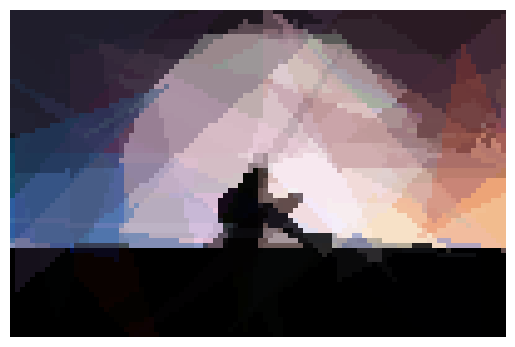

Fitness in Generation 7110: mean: -82.24134871203383, max: -82.20925797770089 min: -82.26774317570165
Fitness in Generation 7120: mean: -82.18888888888888, max: -82.12282968089197 min: -82.20925797770089
Fitness in Generation 7130: mean: -82.09452425990004, max: -82.02714340638217 min: -82.09747020376778
Fitness in Generation 7140: mean: -82.02714340638217, max: -82.02714340638217 min: -82.02714340638217
Fitness in Generation 7150: mean: -82.02714340638217, max: -82.02714340638217 min: -82.02714340638217
Fitness in Generation 7160: mean: -82.02259254133025, max: -82.01265667051133 min: -82.02714340638217
Fitness in Generation 7170: mean: -82.0056221453287, max: -81.99830834294502 min: -82.00681276432141
Fitness in Generation 7180: mean: -81.99830834294504, max: -81.99830834294502 min: -81.99830834294502
Fitness in Generation 7190: mean: -81.99830834294504, max: -81.99830834294502 min: -81.99830834294502
Fitness in Generation 7200: mean: -81.99806228373704, max: -81.99800076893503 min: 

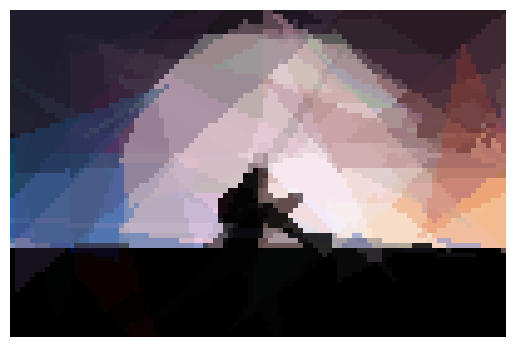

Fitness in Generation 7210: mean: -81.98714186851211, max: -81.96616685890042 min: -81.99800076893503
Fitness in Generation 7220: mean: -81.95251764705883, max: -81.93902345251826 min: -81.96296808919647
Fitness in Generation 7230: mean: -81.93902345251826, max: -81.93902345251826 min: -81.93902345251826
Fitness in Generation 7240: mean: -81.93767935409458, max: -81.93725490196078 min: -81.93902345251826
Fitness in Generation 7250: mean: -81.93457593233371, max: -81.80330642060744 min: -81.93725490196078
Fitness in Generation 7260: mean: -81.80330642060744, max: -81.80330642060744 min: -81.80330642060744
Fitness in Generation 7270: mean: -81.80228035371009, max: -81.79689350249903 min: -81.80330642060744
Fitness in Generation 7280: mean: -81.76631049596308, max: -81.7270895809304 min: -81.79689350249903
Fitness in Generation 7290: mean: -81.72622222222222, max: -81.71624759707804 min: -81.7270895809304
Fitness in Generation 7300: mean: -81.7097574778931, max: -81.69139561707036 min: -8

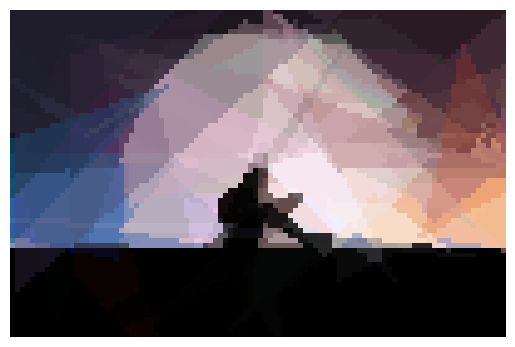

Fitness in Generation 7310: mean: -81.69139561707036, max: -81.69139561707036 min: -81.69139561707036
Fitness in Generation 7320: mean: -81.6906675893887, max: -81.6549942329873 min: -81.69139561707036
Fitness in Generation 7330: mean: -81.64647750865052, max: -81.63896962706652 min: -81.6549942329873
Fitness in Generation 7340: mean: -81.62689734717418, max: -81.62689734717416 min: -81.62689734717416
Fitness in Generation 7350: mean: -81.62631172625913, max: -81.62271434063821 min: -81.62689734717416
Fitness in Generation 7360: mean: -81.60583221837754, max: -81.55595540176854 min: -81.62271434063821
Fitness in Generation 7370: mean: -81.55576778162245, max: -81.55501730103806 min: -81.55595540176854
Fitness in Generation 7380: mean: -81.55429880815069, max: -81.55277201076508 min: -81.55501730103806
Fitness in Generation 7390: mean: -81.54772410611302, max: -81.5442675893887 min: -81.55014225297961
Fitness in Generation 7400: mean: -81.5438274509804, max: -81.52247597078046 min: -81.

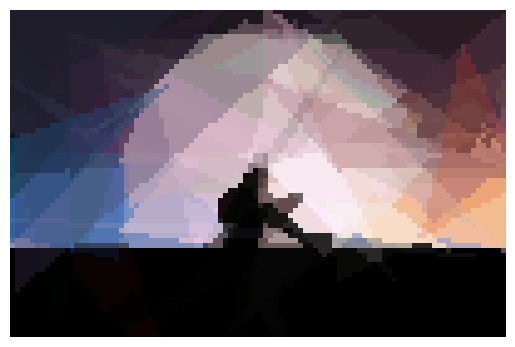

Fitness in Generation 7410: mean: -81.52242214532872, max: -81.52236831987697 min: -81.52247597078046
Fitness in Generation 7420: mean: -81.52236831987697, max: -81.52236831987697 min: -81.52236831987697
Fitness in Generation 7430: mean: -81.50518354479046, max: -81.49850057670126 min: -81.52236831987697
Fitness in Generation 7440: mean: -81.4850983467897, max: -81.45983852364476 min: -81.49850057670126
Fitness in Generation 7450: mean: -81.4337350249904, max: -81.35673971549404 min: -81.45174932718186
Fitness in Generation 7460: mean: -81.33790173010381, max: -81.32195309496348 min: -81.6637754709727
Fitness in Generation 7470: mean: -81.32110634371396, max: -81.3045136485967 min: -81.32195309496348
Fitness in Generation 7480: mean: -81.26303667820069, max: -81.24664359861592 min: -81.2640830449827
Fitness in Generation 7490: mean: -81.24290042291426, max: -81.22980392156862 min: -81.24664359861592
Fitness in Generation 7500: mean: -81.19043075740099, max: -81.17359477124182 min: -81.

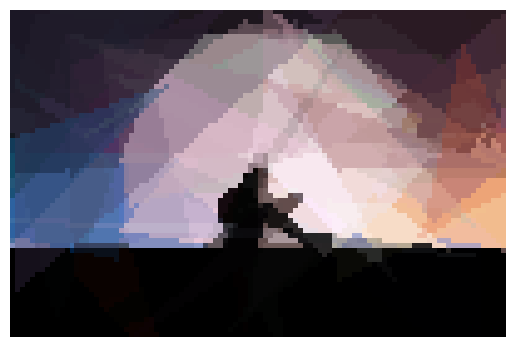

Fitness in Generation 7510: mean: -81.14489811610918, max: -81.14489811610918 min: -81.14489811610918
Fitness in Generation 7520: mean: -81.14489811610918, max: -81.14489811610918 min: -81.14489811610918
Fitness in Generation 7530: mean: -81.13522491349481, max: -81.13067281814686 min: -81.14489811610918
Fitness in Generation 7540: mean: -81.1226399077278, max: -81.09977700884275 min: -81.13067281814686
Fitness in Generation 7550: mean: -81.04587835447904, max: -81.00307574009996 min: -81.09977700884275
Fitness in Generation 7560: mean: -81.00307574009997, max: -81.00307574009996 min: -81.00307574009996
Fitness in Generation 7570: mean: -81.00307574009997, max: -81.00307574009996 min: -81.00307574009996
Fitness in Generation 7580: mean: -81.00186082276048, max: -81.00186082276048 min: -81.00186082276048
Fitness in Generation 7590: mean: -80.98124936562861, max: -80.87780084582853 min: -81.00186082276048
Fitness in Generation 7600: mean: -80.8765287197232, max: -80.87644752018454 min: -

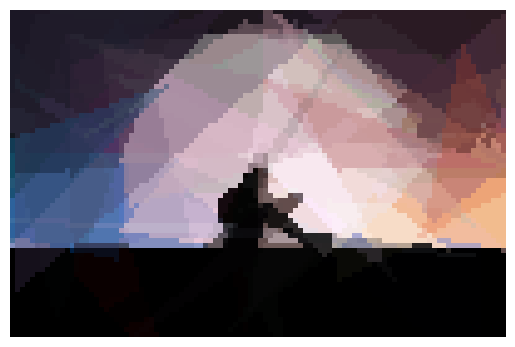

Fitness in Generation 7610: mean: -80.6941419454056, max: -80.55806228373703 min: -80.76995001922337


In [ ]:
target_image_path = r"C:\Users\Asus\Desktop\moon.jpg"
image = Image.open(target_image_path)
# Use resize to resize your images
image = resize(image, 100)

width, height = image.size
population_size = 50
triangles_number = 50
alg = GeneticAlgorithm(width, height, image, population_size, triangles_number)
alg.run(10000)